In [1]:
import numpy as np
import time
import hashlib
import matplotlib.pyplot as plt

In [22]:
class StockExchange:    
    def __init__(self):
        self.epilson = 1e-2
        self.bid = []
        self.ask = []
        self.trades = []

        self.position = {}
        
    def notice(ident, cash, stock):
        print(ident, cash, stock)
        
        
        
    # buy as much stock as possible with cash
    def buy(self, ident, cash, limit=None):
        print("buy - ", ident, cash, limit)
        
        buyer_stock = 0
        updates = []
        
        # inital position change from this action
        updates.append((ident, -cash, 0))
        
        while cash > 0.0 and len(self.ask) > 0:
            other_ident,price,size = self.ask.pop(0)
        
        
            if limit and price > limit:
                self.ask = [(other_ident,price,size)] + self.ask
                break
                
            target = cash/price
            target = min(target,size)

            size -= target
            cash -= target*price
            buyer_stock += target

            # rounding error fix - maybe i shouldnt use floats
            if cash < self.epilson:
                cash = 0.0

            # restore book
            if size > 0:
                self.ask = [(other_ident, price, size)] + self.ask

            updates.append((other_ident, target*price, 0))
            self.trades.append((price, target))
        
        # left over position from this action
        updates.append((ident, cash, buyer_stock))
        return updates
            
    # sell as much stock as possible for best value
    def sell(self, ident, seller_stock, limit=None):
        print("sell - ", ident, seller_stock, limit)
        seller_cash = 0.0
        updates = []
        
        # inital position change from this action
        updates.append((ident, 0, -seller_stock))
        
        while seller_stock > 0.0 and len(self.bid) > 0:
            other_ident,price,size = self.bid.pop(0)
        
            if limit and price < limit:
                self.bid = [(other_ident,price,size)] + self.bid
                break

            target = min(seller_stock,size)
            
            size -= target

            seller_cash  += target*price
            seller_stock -= target
            
            # rounding error fix - maybe i shouldnt use floats
            if seller_stock < self.epilson:
                seller_stock = 0.0
            
            # restore book
            if size > 0.0:
                self.bid = [(other_ident, price, size)] + self.bid
            
            # left over position from this action
            updates.append((other_ident, 0, target))
            self.trades.append((price, target))
            
        updates.append((ident, seller_cash, seller_stock))
        return updates
        
    def cancel(self, ident=None):
        print("cancel - ", ident)
        updates = []
        
        idx = []
        for i in range(len(self.ask)):
            if self.ask[i][0] == ident or ident == None:
                idx.append(i)

        idx.reverse()
        for i in idx:
            other_ident,price,size = self.ask.pop(i)
            updates += [(other_ident, 0, size)] 
    
        idx = []
        for i in range(len(self.bid)):
            if self.bid[i][0] == ident or ident == None:
                idx.append(i)
        
        idx.reverse()
        for i in idx:
            other_ident,price,size = self.bid.pop(i)
            updates += [(other_ident, price*size, 0)] 
            
        return updates

    def insert_bid(self, ident, price, size):
        print("bid order for:", ident, " price:", price, " size:", size)
        
        for i in range(len(self.bid)):
            if self.bid[i][1] < price:
                self.bid.insert(i, (ident,price,size))
                return
        
        self.bid.insert(len(self.bid), (ident,price,size))

    def insert_ask(self, ident, price, size):
        print("ask order for:", ident, " price:", price, " size:", size)
        
        for i in range(len(self.ask)):
            if self.ask[i][1] > price:
                self.ask.insert(i, (ident,price,size))
                return
        
        self.ask.insert(len(self.ask), (ident,price,size))
            
    # public api here
    def buy_limit(self, ident, cash, limit=None):
        updates = self.buy(ident, cash, limit)
        
        if limit is not None:
            # if there was cash left then make the book entry 
            if updates[-1][1] > 0.0:
                # take the last update which is always the final state of the buyer
                ident, cash, stock = updates.pop(-1)
            
                self.insert_bid(ident, limit, cash/limit)
                updates.append((ident,0,stock))   

        for i,p,s in updates:
            print(" + updates for:", i, "cash:", p, " stock:", s)

            if not i in self.position:
                self.position[i] = [0,0]
                
            self.position[i][0] += p
            self.position[i][1] += s

    def sell_limit(self, ident, seller_stock, limit=None):
        updates = self.sell(ident, seller_stock, limit)
        
        if limit is not None:
            # if there was stock left then make the book entry 
            if updates[-1][2] > 0:
                # take the last update which is always the final state of the buyer
                ident, cash, stock = updates.pop(-1)
                
                self.insert_ask(ident, limit, stock)
                updates.append((ident,cash,0))                
                
        for i,p,s in updates:
            print(" + updates for:", i, "cash:", p, " stock:", s)
            
            if not i in self.position:
                self.position[i] = [0,0]
                
            self.position[i][0] += p
            self.position[i][1] += s
    
    def order_cancel(self, ident):
        updates = self.cancel(ident)
        
        for i,p,s in updates:
            print(" + updates ", i,p,s)        

            if not i in self.position:
                self.position[i] = [0,0]
                
            self.position[i][0] += p
            self.position[i][1] += s
    
    def all_cancel(self):
        updates = self.cancel()
        
        for i,p,s in updates:
            print(" + updates ", i,p,s)        

            if not i in self.position:
                self.position[i] = [0,0]
                
            self.position[i][0] += p
            self.position[i][1] += s
    
    def last_price(self):
        if self.trades:
            last_price, _ = self.trades[-1]
        else:
            last_price = 100.0
            
        return last_price
    
    def print_position(self):
        print("standing positions")
        for i in self.position.keys():
            print(i, ": cash:", self.position[i][0], " stock:", self.position[i][1])
        print("")

    def print_adjusted_position(self):
        last = self.last_price()
        
        print("standing positions")
        for i in self.position.keys():
            net = self.position[i][0] + last*self.position[i][1]
            print(i, ": net cash:", net)
        print("")

In [23]:
s = StockExchange()

In [24]:
s.sell_limit("a", 100, limit=100)
s.print_position()
s.order_cancel("a")
s.print_position()
s.sell_limit("b", 100, limit=102)
s.print_position()
s.sell_limit("c", 100, limit=104)
s.print_position()
s.buy_limit("d", 150*101, limit=101)
s.print_position()
s.buy_limit("e", 150*102, limit=102)
s.print_position()
s.all_cancel()
s.print_position()

sell -  a 100 100
ask order for: a  price: 100  size: 100
 + updates for: a cash: 0  stock: -100
 + updates for: a cash: 0.0  stock: 0
standing positions
a : cash: 0.0  stock: -100

cancel -  a
 + updates  a 0 100
standing positions
a : cash: 0.0  stock: 0

sell -  b 100 102
ask order for: b  price: 102  size: 100
 + updates for: b cash: 0  stock: -100
 + updates for: b cash: 0.0  stock: 0
standing positions
a : cash: 0.0  stock: 0
b : cash: 0.0  stock: -100

sell -  c 100 104
ask order for: c  price: 104  size: 100
 + updates for: c cash: 0  stock: -100
 + updates for: c cash: 0.0  stock: 0
standing positions
a : cash: 0.0  stock: 0
b : cash: 0.0  stock: -100
c : cash: 0.0  stock: -100

buy -  d 15150 101
bid order for: d  price: 101  size: 150.0
 + updates for: d cash: -15150  stock: 0
 + updates for: d cash: 0  stock: 0
standing positions
a : cash: 0.0  stock: 0
b : cash: 0.0  stock: -100
c : cash: 0.0  stock: -100
d : cash: -15150  stock: 0

buy -  e 15300 102
bid order for: e  pri

In [25]:
s.ask

[]

In [26]:
s.bid

[]

In [27]:
s.trades

[(102, 100)]

In [28]:
s.last_price()

102

In [29]:
s.print_position()

standing positions
a : cash: 0.0  stock: 0
b : cash: 10200.0  stock: -100
c : cash: 0.0  stock: 0
d : cash: 0.0  stock: 0
e : cash: -10200.0  stock: 100



In [30]:
class RandomAgent:
    def __init__(self):
        self.name = hashlib.sha224(str(time.time()).encode()).hexdigest()[:6]
    
    def act(self, stock):
        last = s.last_price()
        predict = last * (1.0 + 0.1*np.random.normal())
        
        size = np.random.uniform(1000)
                
        stock.order_cancel(self.name)
        if last < predict:
            stock.buy_limit(self.name, size*predict, limit=predict)
        else:
            stock.sell_limit(self.name, size, limit=predict)

In [31]:
agents = [RandomAgent() for i in range(30)]
stock = StockExchange()

In [32]:
for i in range(300):
    for a in agents:
        a.act(stock)
        
stock.all_cancel()

cancel -  ecdc52
buy -  ecdc52 13041.037564970724 104.74137338633261
bid order for: ecdc52  price: 104.74137338633261  size: 124.50703235358196
 + updates for: ecdc52 cash: -13041.037564970724  stock: 0
 + updates for: ecdc52 cash: 0  stock: 0
cancel -  dbe2fc
sell -  dbe2fc 50.22744304915875 99.12923043420096
 + updates for: dbe2fc cash: 0  stock: -50.22744304915875
 + updates for: ecdc52 cash: 0  stock: 50.22744304915875
 + updates for: dbe2fc cash: 5260.891366652693  stock: 0.0
cancel -  e9aeae
buy -  e9aeae 21908.268897335573 117.94300571424688
bid order for: e9aeae  price: 117.94300571424688  size: 185.7530148961531
 + updates for: e9aeae cash: -21908.268897335573  stock: 0
 + updates for: e9aeae cash: 0  stock: 0
cancel -  ce37e5
sell -  ce37e5 539.267641094364 94.9435124219456
ask order for: ce37e5  price: 94.9435124219456  size: 279.23503689378765
 + updates for: ce37e5 cash: 0  stock: -539.267641094364
 + updates for: e9aeae cash: 0  stock: 185.7530148961531
 + updates for: ec

 + updates for: f676bd cash: 6844.846368359893  stock: 0
 + updates for: e4befc cash: 0.0  stock: 71.2369398032648
cancel -  bfd4db
sell -  bfd4db 60.75554634899834 86.82435768983865
ask order for: bfd4db  price: 86.82435768983865  size: 60.75554634899834
 + updates for: bfd4db cash: 0  stock: -60.75554634899834
 + updates for: bfd4db cash: 0.0  stock: 0
cancel -  cba909
buy -  cba909 105046.48365201667 105.13144612282258
bid order for: cba909  price: 105.13144612282258  size: 798.7648363895105
 + updates for: cba909 cash: -105046.48365201667  stock: 0
 + updates for: bfd4db cash: 5275.061287847002  stock: 0
 + updates for: f676bd cash: 15796.12000248066  stock: 0
 + updates for: cba909 cash: 0  stock: 225.15182190945177
cancel -  147b63
sell -  147b63 937.5793550110793 97.79699779037946
ask order for: 147b63  price: 97.79699779037946  size: 138.81451862156882
 + updates for: 147b63 cash: 0  stock: -937.5793550110793
 + updates for: cba909 cash: 0  stock: 798.7648363895105
 + updates f

 + updates for: ce37e5 cash: -59122.016649915524  stock: 0
 + updates for: e9aeae cash: 59122.016649915524  stock: 0
 + updates for: ce37e5 cash: 0.0  stock: 636.304743719362
cancel -  602a21
 + updates  602a21 0 334.2313785760103
buy -  602a21 6961.726392334816 118.59893805411849
 + updates for: 602a21 cash: -6961.726392334816  stock: 0
 + updates for: e9aeae cash: 6961.726392334816  stock: 0
 + updates for: 602a21 cash: 0.0  stock: 74.92605595897334
cancel -  510dbb
sell -  510dbb 323.4783860277937 92.93779917234063
ask order for: 510dbb  price: 92.93779917234063  size: 323.4783860277937
 + updates for: 510dbb cash: 0  stock: -323.4783860277937
 + updates for: 510dbb cash: 0.0  stock: 0
cancel -  b846a3
 + updates  b846a3 0 678.9750327204498
buy -  b846a3 84844.93477617926 124.76908956427003
 + updates for: b846a3 cash: -84844.93477617926  stock: 0
 + updates for: e9aeae cash: 19776.467437277795  stock: 0
 + updates for: 510dbb cash: 30063.369277243968  stock: 0
 + updates for: 567d7

 + updates for: 10b0a3 cash: 0  stock: 455.44055259212246
 + updates for: 42d8ea cash: 68626.23070037212  stock: 0.0
cancel -  33b60b
sell -  33b60b 226.74450888407694 91.9150058447405
 + updates for: 33b60b cash: 0  stock: -226.74450888407694
 + updates for: 10b0a3 cash: 0  stock: 130.0907410712839
 + updates for: e39c81 cash: 0  stock: 96.65376781279303
 + updates for: 33b60b cash: 24002.881303623173  stock: 0.0
cancel -  e7e04e
sell -  e7e04e 987.7074377677211 93.15894493657315
ask order for: e7e04e  price: 93.15894493657315  size: 534.1667733738101
 + updates for: e7e04e cash: 0  stock: -987.7074377677211
 + updates for: e39c81 cash: 0  stock: 453.540664393911
 + updates for: e7e04e cash: 47885.08638169906  stock: 0
cancel -  ecdc52
buy -  ecdc52 13252.451913967476 112.83690609458024
 + updates for: ecdc52 cash: -13252.451913967476  stock: 0
 + updates for: e7e04e cash: 13252.451913967476  stock: 0
 + updates for: ecdc52 cash: 0.0  stock: 142.25635469562636
cancel -  dbe2fc
sell - 

 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
buy -  f1f805 27056.495113461562 117.27549813363457
bid order for: f1f805  price: 117.27549813363457  size: 230.70884834469757
 + updates for: f1f805 cash: -27056.495113461562  stock: 0
 + updates for: f1f805 cash: 0  stock: 0
cancel -  301da5
sell -  301da5 681.0071122132975 93.69426247192396
 + updates for: 301da5 cash: 0  stock: -681.0071122132975
 + updates for: f1f805 cash: 0  stock: 230.70884834469757
 + updates for: bfd4db cash: 0  stock: 450.2982638686
 + updates for: 301da5 cash: 78501.43071247762  stock: 0.0
cancel -  57a381
sell -  57a381 275.51985205495987 97.67163860280776
 + updates for: 57a381 cash: 0  stock: -275.51985205495987
 + updates for: bfd4db cash: 0  stock: 114.85171790375773
 + updates for: cba909 cash: 0  stock: 160.66813415120214
 + updates for: 57a381 cash: 30855.209075123923  stock: 0.0
cancel -  397d0e
buy -  397d0e 88211.55229485882 108.91983353148254
bid order for: 397d0e  price: 108.919833531482

 + updates for: 502657 cash: -9470.389090958513  stock: 0
 + updates for: 567d78 cash: 9470.389090958513  stock: 0
 + updates for: 502657 cash: 0.0  stock: 96.47980593211462
cancel -  25d1a9
buy -  25d1a9 34581.782712211505 107.00846857704389
 + updates for: 25d1a9 cash: -34581.782712211505  stock: 0
 + updates for: 567d78 cash: 34581.782712211505  stock: 0
 + updates for: 25d1a9 cash: 0.0  stock: 352.3027040194222
cancel -  168284
buy -  168284 93219.56397234988 114.64462994931023
 + updates for: 168284 cash: -93219.56397234988  stock: 0
 + updates for: 567d78 cash: 3891.8518967606624  stock: 0
 + updates for: e2b93c cash: 89327.71207558921  stock: 0
 + updates for: 168284 cash: 0.0  stock: 929.1764882316595
cancel -  42d8ea
sell -  42d8ea 605.0712324039646 97.88951889871225
ask order for: 42d8ea  price: 97.88951889871225  size: 605.0712324039646
 + updates for: 42d8ea cash: 0  stock: -605.0712324039646
 + updates for: 42d8ea cash: 0.0  stock: 0
cancel -  33b60b
buy -  33b60b 71203.06

 + updates for: 25d1a9 cash: 0  stock: 277.4920726799345
 + updates for: 168284 cash: 92816.85409966437  stock: 0.0
cancel -  42d8ea
buy -  42d8ea 28964.8625496315 106.06144394690155
bid order for: 42d8ea  price: 106.06144394690155  size: 273.09511799719064
 + updates for: 42d8ea cash: -28964.8625496315  stock: 0
 + updates for: 42d8ea cash: 0  stock: 0
cancel -  33b60b
sell -  33b60b 394.362313245877 101.24435411256167
 + updates for: 33b60b cash: 0  stock: -394.362313245877
 + updates for: 25d1a9 cash: 0  stock: 228.7389286379406
 + updates for: cba909 cash: 0  stock: 165.62338460793637
 + updates for: 33b60b cash: 42577.17224488086  stock: 0.0
cancel -  e7e04e
sell -  e7e04e 674.4121640420954 89.78355605183422
 + updates for: e7e04e cash: 0  stock: -674.4121640420954
 + updates for: cba909 cash: 0  stock: 605.0716126272351
 + updates for: e4befc cash: 0  stock: 69.34055141486022
 + updates for: e7e04e cash: 72489.25120565064  stock: 0.0
cancel -  ecdc52
sell -  ecdc52 829.9254839294

buy -  57a381 85382.16903868386 104.29309189264488
bid order for: 57a381  price: 104.29309189264488  size: 818.6752112649306
 + updates for: 57a381 cash: -85382.16903868386  stock: 0
 + updates for: 57a381 cash: 0  stock: 0
cancel -  397d0e
 + updates  397d0e 14307.932881906461 0
sell -  397d0e 349.9909362663502 79.5249334794
 + updates for: 397d0e cash: 0  stock: -349.9909362663502
 + updates for: e4befc cash: 0  stock: 349.9909362663502
 + updates for: 397d0e cash: 37487.984985038885  stock: 0.0
cancel -  bdb97d
sell -  bdb97d 175.08879414828345 101.82996997725155
 + updates for: bdb97d cash: 0  stock: -175.08879414828345
 + updates for: e4befc cash: 0  stock: 175.08879414828345
 + updates for: bdb97d cash: 18753.988763538393  stock: 0.0
cancel -  0d5eec
buy -  0d5eec 39512.17402640389 119.30670022356976
bid order for: 0d5eec  price: 119.30670022356976  size: 331.18151748696187
 + updates for: 0d5eec cash: -39512.17402640389  stock: 0
 + updates for: 0d5eec cash: 0  stock: 0
cancel -

 + updates for: f676bd cash: 0  stock: 166.32193052508853
 + updates for: e9aeae cash: 0  stock: 192.43679868212598
 + updates for: bfd4db cash: 58968.69964631829  stock: 0.0
cancel -  cba909
sell -  cba909 246.759499983831 98.94754812583871
 + updates for: cba909 cash: 0  stock: -246.759499983831
 + updates for: e9aeae cash: 0  stock: 246.759499983831
 + updates for: cba909 cash: 27492.585454713113  stock: 0.0
cancel -  147b63
buy -  147b63 52177.740980128096 113.4816095713803
bid order for: 147b63  price: 113.4816095713803  size: 459.7902794752671
 + updates for: 147b63 cash: -52177.740980128096  stock: 0
 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
sell -  f1f805 49.6773702276231 91.10070357568188
 + updates for: f1f805 cash: 0  stock: -49.6773702276231
 + updates for: 147b63 cash: 0  stock: 49.6773702276231
 + updates for: f1f805 cash: 5637.467932704037  stock: 0.0
cancel -  301da5
 + updates  301da5 83931.33644212055 0
buy -  301da5 74304.2261313575 106.7486991874309


buy -  602a21 25363.939462358983 105.05953074919054
bid order for: 602a21  price: 105.05953074919054  size: 241.42445032341251
 + updates for: 602a21 cash: -25363.939462358983  stock: 0
 + updates for: 602a21 cash: 0  stock: 0
cancel -  510dbb
buy -  510dbb 97381.66277492799 102.92452302793815
bid order for: 510dbb  price: 102.92452302793815  size: 946.1463595852118
 + updates for: 510dbb cash: -97381.66277492799  stock: 0
 + updates for: 510dbb cash: 0  stock: 0
cancel -  b846a3
sell -  b846a3 626.0592379689965 91.8257579491098
 + updates for: b846a3 cash: 0  stock: -626.0592379689965
 + updates for: ecdc52 cash: 0  stock: 60.91293554669656
 + updates for: 602a21 cash: 0  stock: 241.42445032341251
 + updates for: ce37e5 cash: 0  stock: 323.72185209888744
 + updates for: b846a3 cash: 65851.61146427829  stock: 0.0
cancel -  f676bd
buy -  f676bd 95229.94567111212 109.07110899224124
bid order for: f676bd  price: 109.07110899224124  size: 873.0996370256609
 + updates for: f676bd cash: -952

buy -  567d78 31212.53796204043 104.25465084677884
bid order for: 567d78  price: 104.25465084677884  size: 299.3874873545251
 + updates for: 567d78 cash: -31212.53796204043  stock: 0
 + updates for: 567d78 cash: 0  stock: 0
cancel -  4f4d8a
sell -  4f4d8a 775.4142403875775 83.1405608015053
 + updates for: 4f4d8a cash: 0  stock: -775.4142403875775
 + updates for: bdb97d cash: 0  stock: 194.3405937493211
 + updates for: 25d1a9 cash: 0  stock: 130.998645914211
 + updates for: 42d8ea cash: 0  stock: 450.07500072404537
 + updates for: 4f4d8a cash: 82201.51452361388  stock: 0.0
cancel -  e39c81
buy -  e39c81 795.8624881747241 112.17981881306272
bid order for: e39c81  price: 112.17981881306272  size: 7.094524635495759
 + updates for: e39c81 cash: -795.8624881747241  stock: 0
 + updates for: e39c81 cash: 0  stock: 0
cancel -  10b0a3
buy -  10b0a3 50324.37019863869 104.60942417785425
bid order for: 10b0a3  price: 104.60942417785425  size: 481.0691827638635
 + updates for: 10b0a3 cash: -50324.37

 + updates for: dbe2fc cash: 22995.429893908313  stock: 0
 + updates for: e7e04e cash: 3668.1533796496446  stock: 0
 + updates for: 57a381 cash: 0.0  stock: 300.67492915969694
cancel -  397d0e
sell -  397d0e 105.49131826757593 97.20357005820675
ask order for: 397d0e  price: 97.20357005820675  size: 105.49131826757593
 + updates for: 397d0e cash: 0  stock: -105.49131826757593
 + updates for: 397d0e cash: 0.0  stock: 0
cancel -  bdb97d
sell -  bdb97d 734.2692747301937 90.56314129553904
ask order for: bdb97d  price: 90.56314129553904  size: 734.2692747301937
 + updates for: bdb97d cash: 0  stock: -734.2692747301937
 + updates for: bdb97d cash: 0.0  stock: 0
cancel -  0d5eec
 + updates  0d5eec 0 985.7579661575104
sell -  0d5eec 583.4168171626376 88.26551325723322
ask order for: 0d5eec  price: 88.26551325723322  size: 583.4168171626376
 + updates for: 0d5eec cash: 0  stock: -583.4168171626376
 + updates for: 0d5eec cash: 0.0  stock: 0
cancel -  567d78
 + updates  567d78 0 242.43298303491792

 + updates for: e4befc cash: -9780.411154077898  stock: 0
 + updates for: ce37e5 cash: 9780.411154077898  stock: 0
 + updates for: e4befc cash: 0.0  stock: 103.49345365918715
cancel -  bfd4db
buy -  bfd4db 22951.370920828547 116.71271250130869
 + updates for: bfd4db cash: -22951.370920828547  stock: 0
 + updates for: ce37e5 cash: 16054.246240347382  stock: 0
 + updates for: f676bd cash: 6897.124680481165  stock: 0
 + updates for: bfd4db cash: 0.0  stock: 241.21052818544175
cancel -  cba909
 + updates  cba909 0 779.5861163794054
sell -  cba909 820.3282630863954 99.12255936423564
ask order for: cba909  price: 99.12255936423564  size: 820.3282630863954
 + updates for: cba909 cash: 0  stock: -820.3282630863954
 + updates for: cba909 cash: 0.0  stock: 0
cancel -  147b63
 + updates  147b63 0 188.8770434311839
sell -  147b63 674.4644390903783 72.49308518533441
ask order for: 147b63  price: 72.49308518533441  size: 674.4644390903783
 + updates for: 147b63 cash: 0  stock: -674.4644390903783
 + 

bid order for: e9aeae  price: 117.03125218228256  size: 234.08062497250407
 + updates for: e9aeae cash: -116993.42123767831  stock: 0
 + updates for: e7e04e cash: 89598.67258553488  stock: 0
 + updates for: e9aeae cash: 0  stock: 891.1493083823444
cancel -  ce37e5
buy -  ce37e5 102716.57282793931 111.26619893352402
bid order for: ce37e5  price: 111.26619893352402  size: 923.1606167233889
 + updates for: ce37e5 cash: -102716.57282793931  stock: 0
 + updates for: ce37e5 cash: 0  stock: 0
cancel -  602a21
buy -  602a21 116744.65507401749 123.01570831738294
bid order for: 602a21  price: 123.01570831738294  size: 949.0223376417423
 + updates for: 602a21 cash: -116744.65507401749  stock: 0
 + updates for: 602a21 cash: 0  stock: 0
cancel -  510dbb
sell -  510dbb 922.0273264054347 87.93289563041743
 + updates for: 510dbb cash: 0  stock: -922.0273264054347
 + updates for: 602a21 cash: 0  stock: 922.0273264054347
 + updates for: 510dbb cash: 113423.84464574739  stock: 0.0
cancel -  b846a3
buy - 

bid order for: 42d8ea  price: 105.0137886423778  size: 689.0615622546416
 + updates for: 42d8ea cash: -72360.96526019559  stock: 0
 + updates for: 42d8ea cash: 0  stock: 0
cancel -  33b60b
sell -  33b60b 290.0184041347195 85.6765305359598
 + updates for: 33b60b cash: 0  stock: -290.0184041347195
 + updates for: 42d8ea cash: 0  stock: 290.0184041347195
 + updates for: 33b60b cash: 30455.931394203144  stock: 0.0
cancel -  e7e04e
buy -  e7e04e 41837.60395898936 113.00103213503336
bid order for: e7e04e  price: 113.00103213503336  size: 370.2409010653504
 + updates for: e7e04e cash: -41837.60395898936  stock: 0
 + updates for: e7e04e cash: 0  stock: 0
cancel -  ecdc52
sell -  ecdc52 271.52565285273226 100.39380304149536
 + updates for: ecdc52 cash: 0  stock: -271.52565285273226
 + updates for: e7e04e cash: 0  stock: 271.52565285273226
 + updates for: ecdc52 cash: 30682.67902349751  stock: 0.0
cancel -  dbe2fc
sell -  dbe2fc 295.3441170559779 98.63880191701692
 + updates for: dbe2fc cash: 0 

 + updates for: f1f805 cash: -14576.745978409159  stock: 0
 + updates for: e4befc cash: 14576.745978409159  stock: 0
 + updates for: f1f805 cash: 0.0  stock: 170.9073256527594
cancel -  301da5
 + updates  301da5 0 363.4963614324396
sell -  301da5 880.8384907763393 82.66130502298319
ask order for: 301da5  price: 82.66130502298319  size: 880.8384907763393
 + updates for: 301da5 cash: 0  stock: -880.8384907763393
 + updates for: 301da5 cash: 0.0  stock: 0
cancel -  57a381
 + updates  57a381 0 831.3504559985929
buy -  57a381 6794.056064713356 122.61988881434056
 + updates for: 57a381 cash: -6794.056064713356  stock: 0
 + updates for: 301da5 cash: 6794.056064713356  stock: 0
 + updates for: 57a381 cash: 0.0  stock: 82.19149289772686
cancel -  397d0e
buy -  397d0e 78213.1045553326 116.14252942659473
 + updates for: 397d0e cash: -78213.1045553326  stock: 0
 + updates for: 301da5 cash: 66017.20309733378  stock: 0
 + updates for: e4befc cash: 678.3616909941278  stock: 0
 + updates for: bfd4db c

cancel -  168284
buy -  168284 65072.83725910561 108.85828231776449
bid order for: 168284  price: 108.85828231776449  size: 597.7757123629208
 + updates for: 168284 cash: -65072.83725910561  stock: 0
 + updates for: 168284 cash: 0  stock: 0
cancel -  42d8ea
sell -  42d8ea 57.90512769946713 97.23668206610044
 + updates for: 42d8ea cash: 0  stock: -57.90512769946713
 + updates for: 0d5eec cash: 0  stock: 57.90512769946713
 + updates for: 42d8ea cash: 6787.777397477381  stock: 0.0
cancel -  33b60b
buy -  33b60b 34891.08601317145 107.25721955851722
bid order for: 33b60b  price: 107.25721955851722  size: 325.3029134708795
 + updates for: 33b60b cash: -34891.08601317145  stock: 0
 + updates for: 33b60b cash: 0  stock: 0
cancel -  e7e04e
buy -  e7e04e 93830.02635326718 109.24573038612188
bid order for: e7e04e  price: 109.24573038612188  size: 858.8896428412452
 + updates for: e7e04e cash: -93830.02635326718  stock: 0
 + updates for: e7e04e cash: 0  stock: 0
cancel -  ecdc52
 + updates  ecdc52

 + updates for: e4befc cash: 0  stock: -147.68491384539834
 + updates for: e4befc cash: 0.0  stock: 0
cancel -  bfd4db
sell -  bfd4db 569.94982764874 89.646827154645
ask order for: bfd4db  price: 89.646827154645  size: 569.94982764874
 + updates for: bfd4db cash: 0  stock: -569.94982764874
 + updates for: bfd4db cash: 0.0  stock: 0
cancel -  cba909
buy -  cba909 55551.892308005656 107.34439518139955
 + updates for: cba909 cash: -55551.892308005656  stock: 0
 + updates for: bfd4db cash: 51094.193686046296  stock: 0
 + updates for: e4befc cash: 4457.69862195936  stock: 0
 + updates for: cba909 cash: 0.0  stock: 619.220918846237
cancel -  147b63
sell -  147b63 997.6650954014972 86.54628519531029
ask order for: 147b63  price: 86.54628519531029  size: 997.6650954014972
 + updates for: 147b63 cash: 0  stock: -997.6650954014972
 + updates for: 147b63 cash: 0.0  stock: 0
cancel -  f1f805
sell -  f1f805 408.6867065275136 82.19252038059027
ask order for: f1f805  price: 82.19252038059027  size: 4

 + updates for: 4081b6 cash: -88975.59538549291  stock: 0
 + updates for: e2b93c cash: 9168.137334105913  stock: 0
 + updates for: 567d78 cash: 60331.12372958318  stock: 0
 + updates for: f676bd cash: 19476.33432180382  stock: 0
 + updates for: 4081b6 cash: 0.0  stock: 926.7383390024614
cancel -  502657
buy -  502657 67173.87588384403 105.9408927421036
 + updates for: 502657 cash: -67173.87588384403  stock: 0
 + updates for: f676bd cash: 34080.90358638909  stock: 0
 + updates for: 602a21 cash: 33092.97229745494  stock: 0
 + updates for: 502657 cash: 0.0  stock: 684.3590408691907
cancel -  25d1a9
buy -  25d1a9 46213.10360190591 112.20234456740069
 + updates for: 25d1a9 cash: -46213.10360190591  stock: 0
 + updates for: 602a21 cash: 46213.10360190591  stock: 0
 + updates for: 25d1a9 cash: 0.0  stock: 469.7999587984035
cancel -  168284
sell -  168284 335.6580316657095 98.39586683586322
ask order for: 168284  price: 98.39586683586322  size: 335.6580316657095
 + updates for: 168284 cash: 0 

ask order for: e4befc  price: 101.80350871731027  size: 489.203240888413
 + updates for: e4befc cash: 0  stock: -489.203240888413
 + updates for: e4befc cash: 0.0  stock: 0
cancel -  bfd4db
buy -  bfd4db 88474.20408816665 114.37253074659115
 + updates for: bfd4db cash: -88474.20408816665  stock: 0
 + updates for: 510dbb cash: 78351.53640730791  stock: 0
 + updates for: e39c81 cash: 3673.9292198836306  stock: 0
 + updates for: 4081b6 cash: 6448.738460975105  stock: 0
 + updates for: bfd4db cash: 0.0  stock: 1087.2584188440362
cancel -  cba909
buy -  cba909 92021.1698702563 118.86316184217345
 + updates for: cba909 cash: -92021.1698702563  stock: 0
 + updates for: 4081b6 cash: 16191.27528581956  stock: 0
 + updates for: 10b0a3 cash: 75829.89458443674  stock: 0
 + updates for: cba909 cash: 0.0  stock: 1008.6767548533905
cancel -  147b63
 + updates  147b63 0 209.94653246556618
sell -  147b63 248.12665779485587 92.98381088205018
ask order for: 147b63  price: 92.98381088205018  size: 248.126

 + updates for: e39c81 cash: 0.0  stock: 0
cancel -  10b0a3
 + updates  10b0a3 0 964.1122447485662
buy -  10b0a3 57972.999215730066 105.93378191226444
 + updates for: 10b0a3 cash: -57972.999215730066  stock: 0
 + updates for: 567d78 cash: 24112.70637621613  stock: 0
 + updates for: 4f4d8a cash: 33860.29283951393  stock: 0
 + updates for: 10b0a3 cash: 0.0  stock: 715.2853776804975
cancel -  e2b93c
sell -  e2b93c 196.20329553786758 96.85877582876579
ask order for: e2b93c  price: 96.85877582876579  size: 196.20329553786758
 + updates for: e2b93c cash: 0  stock: -196.20329553786758
 + updates for: e2b93c cash: 0.0  stock: 0
cancel -  4081b6
sell -  4081b6 447.2955739013429 93.42511958582683
ask order for: 4081b6  price: 93.42511958582683  size: 447.2955739013429
 + updates for: 4081b6 cash: 0  stock: -447.2955739013429
 + updates for: 4081b6 cash: 0.0  stock: 0
cancel -  502657
sell -  502657 480.60597715163647 84.5404058173248
ask order for: 502657  price: 84.5404058173248  size: 480.6059

buy -  ce37e5 93245.02195476592 102.50679346444635
bid order for: ce37e5  price: 102.50679346444635  size: 909.6472419372595
 + updates for: ce37e5 cash: -93245.02195476592  stock: 0
 + updates for: ce37e5 cash: 0  stock: 0
cancel -  602a21
buy -  602a21 47162.35363434856 116.19954232238894
bid order for: 602a21  price: 116.19954232238894  size: 405.8738329923824
 + updates for: 602a21 cash: -47162.35363434856  stock: 0
 + updates for: 602a21 cash: 0  stock: 0
cancel -  510dbb
buy -  510dbb 22012.696770090515 109.94439460304352
bid order for: 510dbb  price: 109.94439460304352  size: 200.21663541436382
 + updates for: 510dbb cash: -22012.696770090515  stock: 0
 + updates for: 510dbb cash: 0  stock: 0
cancel -  b846a3
buy -  b846a3 99392.48845786501 104.6331335833589
bid order for: b846a3  price: 104.6331335833589  size: 949.9140956022426
 + updates for: b846a3 cash: -99392.48845786501  stock: 0
 + updates for: b846a3 cash: 0  stock: 0
cancel -  f676bd
buy -  f676bd 43374.738244690234 10

 + updates for: 397d0e cash: 0  stock: 240.5727805902048
 + updates for: bdb97d cash: 27086.986596709452  stock: 0
cancel -  0d5eec
sell -  0d5eec 2.8555555178098757 89.83863225778953
ask order for: 0d5eec  price: 89.83863225778953  size: 2.8555555178098757
 + updates for: 0d5eec cash: 0  stock: -2.8555555178098757
 + updates for: 0d5eec cash: 0.0  stock: 0
cancel -  567d78
sell -  567d78 846.9982742157811 91.24482918212841
ask order for: 567d78  price: 91.24482918212841  size: 846.9982742157811
 + updates for: 567d78 cash: 0  stock: -846.9982742157811
 + updates for: 567d78 cash: 0.0  stock: 0
cancel -  4f4d8a
buy -  4f4d8a 4532.07931728345 104.0681645712163
 + updates for: 4f4d8a cash: -4532.07931728345  stock: 0
 + updates for: 0d5eec cash: 256.5392020562232  stock: 0
 + updates for: 567d78 cash: 4275.540115227227  stock: 0
 + updates for: 4f4d8a cash: 0.0  stock: 49.713444929746565
cancel -  e39c81
buy -  e39c81 57579.024141007576 111.5103957590768
 + updates for: e39c81 cash: -575

 + updates for: 42d8ea cash: 52714.54931904951  stock: 0
 + updates for: ecdc52 cash: 15191.546548637685  stock: 0
 + updates for: dbe2fc cash: 0.0  stock: 725.0634898917809
cancel -  e9aeae
sell -  e9aeae 653.8912774659614 82.25646048153752
ask order for: e9aeae  price: 82.25646048153752  size: 653.8912774659614
 + updates for: e9aeae cash: 0  stock: -653.8912774659614
 + updates for: e9aeae cash: 0.0  stock: 0
cancel -  ce37e5
buy -  ce37e5 49575.53703677289 103.90172974359086
 + updates for: ce37e5 cash: -49575.53703677289  stock: 0
 + updates for: e9aeae cash: 49575.53703677289  stock: 0
 + updates for: ce37e5 cash: 0.0  stock: 602.6947518353301
cancel -  602a21
 + updates  602a21 0 955.4190446688059
buy -  602a21 94824.2166941799 115.81191877759636
 + updates for: 602a21 cash: -94824.2166941799  stock: 0
 + updates for: e9aeae cash: 4211.244987328046  stock: 0
 + updates for: ecdc52 cash: 5063.015275824013  stock: 0
 + updates for: 567d78 cash: 30055.845553895917  stock: 0
 + upda

 + updates for: 397d0e cash: 0.0  stock: 0
cancel -  bdb97d
sell -  bdb97d 953.8147609646361 99.41130311934342
ask order for: bdb97d  price: 99.41130311934342  size: 953.8147609646361
 + updates for: bdb97d cash: 0  stock: -953.8147609646361
 + updates for: bdb97d cash: 0.0  stock: 0
cancel -  0d5eec
buy -  0d5eec 14176.435564958763 108.62146676957673
 + updates for: 0d5eec cash: -14176.435564958763  stock: 0
 + updates for: 301da5 cash: 14176.435564958763  stock: 0
 + updates for: 0d5eec cash: 0.0  stock: 149.51766025669264
cancel -  567d78
buy -  567d78 25746.419304031147 111.35337234024507
 + updates for: 567d78 cash: -25746.419304031147  stock: 0
 + updates for: 301da5 cash: 18808.45532605503  stock: 0
 + updates for: 602a21 cash: 2632.7640991338853  stock: 0
 + updates for: bfd4db cash: 4305.199878842232  stock: 0
 + updates for: 567d78 cash: 0.0  stock: 270.5631132612558
cancel -  4f4d8a
buy -  4f4d8a 54059.72235317774 122.61842352780182
 + updates for: 4f4d8a cash: -54059.722353

ask order for: 33b60b  price: 91.9788807230155  size: 28.735218989212626
 + updates for: 33b60b cash: 0  stock: -28.735218989212626
 + updates for: 33b60b cash: 0.0  stock: 0
cancel -  e7e04e
buy -  e7e04e 55307.85862654971 110.46814676765119
 + updates for: e7e04e cash: -55307.85862654971  stock: 0
 + updates for: 502657 cash: 1173.2013310004768  stock: 0
 + updates for: 33b60b cash: 2643.033279958518  stock: 0
 + updates for: 42d8ea cash: 51491.624015590714  stock: 0
 + updates for: e7e04e cash: 0.0  stock: 550.8860354128697
cancel -  ecdc52
buy -  ecdc52 81606.03132802963 103.12465058854929
bid order for: ecdc52  price: 103.12465058854929  size: 323.0602161265874
 + updates for: ecdc52 cash: -81606.03132802963  stock: 0
 + updates for: 42d8ea cash: 48290.55942091408  stock: 0
 + updates for: ecdc52 cash: 0  stock: 477.1989938848314
cancel -  dbe2fc
sell -  dbe2fc 232.94710004687818 91.40525331109814
 + updates for: dbe2fc cash: 0  stock: -232.94710004687818
 + updates for: ecdc52 ca

sell -  301da5 13.600927810270605 95.76350741399756
 + updates for: 301da5 cash: 0  stock: -13.600927810270605
 + updates for: f1f805 cash: 0  stock: 13.600927810270605
 + updates for: 301da5 cash: 1440.038824218438  stock: 0.0
cancel -  57a381
sell -  57a381 246.8816316882186 84.54489918677596
 + updates for: 57a381 cash: 0  stock: -246.8816316882186
 + updates for: f1f805 cash: 0  stock: 246.8816316882186
 + updates for: 57a381 cash: 26139.329579336863  stock: 0.0
cancel -  397d0e
buy -  397d0e 87358.91185673048 102.46455924784355
bid order for: 397d0e  price: 102.46455924784355  size: 852.576856798113
 + updates for: 397d0e cash: -87358.91185673048  stock: 0
 + updates for: 397d0e cash: 0  stock: 0
cancel -  bdb97d
sell -  bdb97d 126.45556801231703 100.44127004507341
 + updates for: bdb97d cash: 0  stock: -126.45556801231703
 + updates for: f1f805 cash: 0  stock: 126.45556801231703
 + updates for: bdb97d cash: 13388.860673079967  stock: 0.0
cancel -  0d5eec
sell -  0d5eec 92.7286666

sell -  42d8ea 312.4442526774793 99.66270505978838
ask order for: 42d8ea  price: 99.66270505978838  size: 312.4442526774793
 + updates for: 42d8ea cash: 0  stock: -312.4442526774793
 + updates for: 42d8ea cash: 0.0  stock: 0
cancel -  33b60b
buy -  33b60b 77948.69978726962 107.64802825300136
 + updates for: 33b60b cash: -77948.69978726962  stock: 0
 + updates for: 4f4d8a cash: 22627.298684193567  stock: 0
 + updates for: bdb97d cash: 21895.68763815003  stock: 0
 + updates for: 168284 cash: 33425.713464926026  stock: 0
 + updates for: 33b60b cash: 0.0  stock: 840.538442306506
cancel -  e7e04e
sell -  e7e04e 660.1486695243477 91.72380286940744
ask order for: e7e04e  price: 91.72380286940744  size: 660.1486695243477
 + updates for: e7e04e cash: 0  stock: -660.1486695243477
 + updates for: e7e04e cash: 0.0  stock: 0
cancel -  ecdc52
buy -  ecdc52 65629.29347298079 111.5256754141844
 + updates for: ecdc52 cash: -65629.29347298079  stock: 0
 + updates for: e7e04e cash: 60551.34642795286  sto

 + updates for: cba909 cash: -2109.2139262391515  stock: 0
 + updates for: cba909 cash: 0  stock: 0
cancel -  147b63
buy -  147b63 8950.107475283701 109.09671876476955
bid order for: 147b63  price: 109.09671876476955  size: 82.03828287981423
 + updates for: 147b63 cash: -8950.107475283701  stock: 0
 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
sell -  f1f805 526.5526911967447 99.65092738205868
 + updates for: f1f805 cash: 0  stock: -526.5526911967447
 + updates for: f676bd cash: 0  stock: 42.073374787868374
 + updates for: bfd4db cash: 0  stock: 484.47931640887634
 + updates for: f1f805 cash: 57814.78819149596  stock: 0.0
cancel -  301da5
sell -  301da5 600.967999164277 95.86350813494148
 + updates for: 301da5 cash: 0  stock: -600.967999164277
 + updates for: bfd4db cash: 0  stock: 76.18017965947854
 + updates for: 147b63 cash: 0  stock: 82.03828287981423
 + updates for: 602a21 cash: 0  stock: 220.49732659315646
 + updates for: 397d0e cash: 0  stock: 222.25221003182776
 + u

 + updates for: e2b93c cash: 0.0  stock: 567.2126600578665
cancel -  4081b6
sell -  4081b6 263.18784306948385 84.86368157255582
ask order for: 4081b6  price: 84.86368157255582  size: 263.18784306948385
 + updates for: 4081b6 cash: 0  stock: -263.18784306948385
 + updates for: 4081b6 cash: 0.0  stock: 0
cancel -  502657
buy -  502657 97056.44481623446 133.766814015012
 + updates for: 502657 cash: -97056.44481623446  stock: 0
 + updates for: 4081b6 cash: 22335.089308016468  stock: 0
 + updates for: cba909 cash: 32932.90261259352  stock: 0
 + updates for: e4befc cash: 41788.452895624476  stock: 0
 + updates for: 502657 cash: 0.0  stock: 1039.2808164164348
cancel -  25d1a9
buy -  25d1a9 110286.31906795628 119.10250233879681
 + updates for: 25d1a9 cash: -110286.31906795628  stock: 0
 + updates for: e4befc cash: 31637.08668248971  stock: 0
 + updates for: 147b63 cash: 77472.09710703927  stock: 0
 + updates for: 301da5 cash: 1177.135278427304  stock: 0
 + updates for: 25d1a9 cash: 0.0  stock:

ask order for: b846a3  price: 96.40985240419626  size: 807.2649988135154
 + updates for: b846a3 cash: 0  stock: -807.2649988135154
 + updates for: b846a3 cash: 0.0  stock: 0
cancel -  f676bd
sell -  f676bd 471.6670949240498 87.94967424364187
ask order for: f676bd  price: 87.94967424364187  size: 471.6670949240498
 + updates for: f676bd cash: 0  stock: -471.6670949240498
 + updates for: f676bd cash: 0.0  stock: 0
cancel -  e4befc
buy -  e4befc 38504.108677465585 106.35143120013691
 + updates for: e4befc cash: -38504.108677465585  stock: 0
 + updates for: f676bd cash: 38504.108677465585  stock: 0
 + updates for: e4befc cash: 0.0  stock: 437.7970584723247
cancel -  bfd4db
buy -  bfd4db 46463.64220264016 109.89724205866733
 + updates for: bfd4db cash: -46463.64220264016  stock: 0
 + updates for: f676bd cash: 2978.8586725495006  stock: 0
 + updates for: ce37e5 cash: 43484.78353009066  stock: 0
 + updates for: bfd4db cash: 0.0  stock: 491.7607863338381
cancel -  cba909
sell -  cba909 898.214

 + updates for: 168284 cash: 32512.166086859324  stock: 0
 + updates for: 567d78 cash: 0.0  stock: 1040.8668293890028
cancel -  4f4d8a
sell -  4f4d8a 14.02108861338229 99.08443509482797
ask order for: 4f4d8a  price: 99.08443509482797  size: 14.02108861338229
 + updates for: 4f4d8a cash: 0  stock: -14.02108861338229
 + updates for: 4f4d8a cash: 0.0  stock: 0
cancel -  e39c81
buy -  e39c81 25041.60238028397 109.2961550107047
 + updates for: e39c81 cash: -25041.60238028397  stock: 0
 + updates for: 4f4d8a cash: 1389.271644671509  stock: 0
 + updates for: 168284 cash: 23652.33073561246  stock: 0
 + updates for: e39c81 cash: 0.0  stock: 251.61211783037908
cancel -  10b0a3
 + updates  10b0a3 0 657.3308037529404
sell -  10b0a3 810.0204894078742 82.37319140246994
ask order for: 10b0a3  price: 82.37319140246994  size: 810.0204894078742
 + updates for: 10b0a3 cash: 0  stock: -810.0204894078742
 + updates for: 10b0a3 cash: 0.0  stock: 0
cancel -  e2b93c
sell -  e2b93c 106.69122734219343 83.614674

 + updates for: ecdc52 cash: 0  stock: 0
cancel -  dbe2fc
buy -  dbe2fc 98520.2673225877 108.02952084633225
bid order for: dbe2fc  price: 108.02952084633225  size: 911.9754170041067
 + updates for: dbe2fc cash: -98520.2673225877  stock: 0
 + updates for: dbe2fc cash: 0  stock: 0
cancel -  e9aeae
buy -  e9aeae 98424.98344285994 103.7071715270747
bid order for: e9aeae  price: 103.7071715270747  size: 949.0663181105489
 + updates for: e9aeae cash: -98424.98344285994  stock: 0
 + updates for: e9aeae cash: 0  stock: 0
cancel -  ce37e5
sell -  ce37e5 867.8358249226528 78.40469411744154
 + updates for: ce37e5 cash: 0  stock: -867.8358249226528
 + updates for: dbe2fc cash: 0  stock: 867.8358249226528
 + updates for: ce37e5 cash: 93751.88833967567  stock: 0.0
cancel -  602a21
buy -  602a21 50121.939974344605 103.04651786032188
bid order for: 602a21  price: 103.04651786032188  size: 486.40110325983255
 + updates for: 602a21 cash: -50121.939974344605  stock: 0
 + updates for: 602a21 cash: 0  stoc

cancel -  57a381
buy -  57a381 77876.22346496461 111.36250699656864
bid order for: 57a381  price: 111.36250699656864  size: 699.3037923200146
 + updates for: 57a381 cash: -77876.22346496461  stock: 0
 + updates for: 57a381 cash: 0  stock: 0
cancel -  397d0e
sell -  397d0e 756.06218707828 97.4492136737662
 + updates for: 397d0e cash: 0  stock: -756.06218707828
 + updates for: 301da5 cash: 0  stock: 756.06218707828
 + updates for: 397d0e cash: 95920.28020545257  stock: 0.0
cancel -  bdb97d
sell -  bdb97d 117.84846061561097 98.8953293041255
 + updates for: bdb97d cash: 0  stock: -117.84846061561097
 + updates for: 301da5 cash: 0  stock: 45.783771547240576
 + updates for: 57a381 cash: 0  stock: 72.0646890683704
 + updates for: bdb97d cash: 13833.811030026089  stock: 0.0
cancel -  0d5eec
sell -  0d5eec 208.4992706109648 94.38252667166674
 + updates for: 0d5eec cash: 0  stock: -208.4992706109648
 + updates for: 57a381 cash: 0  stock: 208.4992706109648
 + updates for: 0d5eec cash: 23219.00148

 + updates for: 42d8ea cash: 0  stock: 0
cancel -  33b60b
buy -  33b60b 5373.555272270074 117.63359431097969
bid order for: 33b60b  price: 117.63359431097969  size: 45.68044786648602
 + updates for: 33b60b cash: -5373.555272270074  stock: 0
 + updates for: 33b60b cash: 0  stock: 0
cancel -  e7e04e
buy -  e7e04e 106646.92899603865 116.4220961658776
bid order for: e7e04e  price: 116.4220961658776  size: 916.0368392962849
 + updates for: e7e04e cash: -106646.92899603865  stock: 0
 + updates for: e7e04e cash: 0  stock: 0
cancel -  ecdc52
buy -  ecdc52 79574.62097355703 110.35320507369293
bid order for: ecdc52  price: 110.35320507369293  size: 721.0902566936572
 + updates for: ecdc52 cash: -79574.62097355703  stock: 0
 + updates for: ecdc52 cash: 0  stock: 0
cancel -  dbe2fc
sell -  dbe2fc 687.5286701484404 92.14776642233686
 + updates for: dbe2fc cash: 0  stock: -687.5286701484404
 + updates for: 33b60b cash: 0  stock: 45.68044786648602
 + updates for: 168284 cash: 0  stock: 156.8890866949

 + updates for: 147b63 cash: 51429.21962806846  stock: 0.0
cancel -  f1f805
sell -  f1f805 255.07431305974444 101.553368870881
 + updates for: f1f805 cash: 0  stock: -255.07431305974444
 + updates for: e4befc cash: 0  stock: 126.38258096571633
 + updates for: ce37e5 cash: 0  stock: 10.607279854725789
 + updates for: cba909 cash: 0  stock: 118.08445223930232
 + updates for: f1f805 cash: 28885.78548111902  stock: 0.0
cancel -  301da5
buy -  301da5 7699.556911979294 106.93584172622393
bid order for: 301da5  price: 106.93584172622393  size: 72.00164872402297
 + updates for: 301da5 cash: -7699.556911979294  stock: 0
 + updates for: 301da5 cash: 0  stock: 0
cancel -  57a381
sell -  57a381 648.0024822619594 99.41148753663194
 + updates for: 57a381 cash: 0  stock: -648.0024822619594
 + updates for: cba909 cash: 0  stock: 536.4964551401248
 + updates for: 502657 cash: 0  stock: 111.50602712183456
 + updates for: 57a381 cash: 71403.25347144969  stock: 0.0
cancel -  397d0e
buy -  397d0e 39615.130

 + updates for: 4081b6 cash: -23030.000238135646  stock: 0
 + updates for: e2b93c cash: 23030.00023813565  stock: 0
 + updates for: 4081b6 cash: 0.0  stock: 260.1077336219156
cancel -  502657
sell -  502657 22.111416554004904 96.00672343559495
ask order for: 502657  price: 96.00672343559495  size: 22.111416554004904
 + updates for: 502657 cash: 0  stock: -22.111416554004904
 + updates for: 502657 cash: 0.0  stock: 0
cancel -  25d1a9
sell -  25d1a9 253.21255268822665 101.83447941985315
ask order for: 25d1a9  price: 101.83447941985315  size: 253.21255268822665
 + updates for: 25d1a9 cash: 0  stock: -253.21255268822665
 + updates for: 25d1a9 cash: 0.0  stock: 0
cancel -  168284
sell -  168284 851.9340273063533 74.59954728745042
ask order for: 168284  price: 74.59954728745042  size: 851.9340273063533
 + updates for: 168284 cash: 0  stock: -851.9340273063533
 + updates for: 168284 cash: 0.0  stock: 0
cancel -  42d8ea
sell -  42d8ea 192.42450260685644 90.45822276144264
ask order for: 42d8ea 

 + updates for: e4befc cash: 0  stock: -389.64980265288034
 + updates for: b846a3 cash: 0  stock: 389.64980265288034
 + updates for: e4befc cash: 49858.09455755398  stock: 0.0
cancel -  bfd4db
buy -  bfd4db 1089.151619287505 108.33423431538405
bid order for: bfd4db  price: 108.33423431538405  size: 10.053623641412855
 + updates for: bfd4db cash: -1089.151619287505  stock: 0
 + updates for: bfd4db cash: 0  stock: 0
cancel -  cba909
 + updates  cba909 18527.044938152554 0
sell -  cba909 91.96442837298684 82.84949239729484
 + updates for: cba909 cash: 0  stock: -91.96442837298684
 + updates for: b846a3 cash: 0  stock: 91.96442837298684
 + updates for: cba909 cash: 11767.415598658676  stock: 0.0
cancel -  147b63
sell -  147b63 797.6416576753145 87.34097561144564
 + updates for: 147b63 cash: 0  stock: -797.6416576753145
 + updates for: b846a3 cash: 0  stock: 57.75842926998348
 + updates for: dbe2fc cash: 0  stock: 133.53166776189744
 + updates for: bfd4db cash: 0  stock: 10.053623641412855


sell -  e2b93c 887.608779224614 85.92194139514855
 + updates for: e2b93c cash: 0  stock: -887.608779224614
 + updates for: ecdc52 cash: 0  stock: 359.3668116485254
 + updates for: 42d8ea cash: 0  stock: 519.5935393892355
 + updates for: dbe2fc cash: 0  stock: 8.648428186853039
 + updates for: e2b93c cash: 93420.31254027918  stock: 0.0
cancel -  4081b6
 + updates  4081b6 90271.40208026906 0
buy -  4081b6 57513.12431823541 118.35035240265012
bid order for: 4081b6  price: 118.35035240265012  size: 485.95651090725073
 + updates for: 4081b6 cash: -57513.12431823541  stock: 0
 + updates for: 4081b6 cash: 0  stock: 0
cancel -  502657
sell -  502657 832.3282810568103 96.09650120234272
 + updates for: 502657 cash: 0  stock: -832.3282810568103
 + updates for: 4081b6 cash: 0  stock: 485.95651090725073
 + updates for: dbe2fc cash: 0  stock: 346.37177014955955
 + updates for: 502657 cash: 93627.36800221857  stock: 0.0
cancel -  25d1a9
buy -  25d1a9 32151.760381529944 104.16111096781036
bid order fo

 + updates for: 602a21 cash: -82674.81727571499  stock: 0
 + updates for: 602a21 cash: 0  stock: 0
cancel -  510dbb
buy -  510dbb 101429.52674978384 111.74033356957324
bid order for: 510dbb  price: 111.74033356957324  size: 907.725290497996
 + updates for: 510dbb cash: -101429.52674978384  stock: 0
 + updates for: 510dbb cash: 0  stock: 0
cancel -  b846a3
sell -  b846a3 369.5711160585081 95.94014786536607
 + updates for: b846a3 cash: 0  stock: -369.5711160585081
 + updates for: 510dbb cash: 0  stock: 369.5711160585081
 + updates for: b846a3 cash: 41295.99978605716  stock: 0.0
cancel -  f676bd
buy -  f676bd 19492.441277293114 107.97326879413235
bid order for: f676bd  price: 107.97326879413235  size: 180.53025063507573
 + updates for: f676bd cash: -19492.441277293114  stock: 0
 + updates for: f676bd cash: 0  stock: 0
cancel -  e4befc
 + updates  e4befc 72238.41538681446 0
buy -  e4befc 73241.40591905134 108.82273156902119
bid order for: e4befc  price: 108.82273156902119  size: 673.034069

ask order for: 567d78  price: 95.42569720260708  size: 768.9130664021892
 + updates for: 567d78 cash: 0  stock: -992.9745523751778
 + updates for: 397d0e cash: 0  stock: 39.43989334229866
 + updates for: 147b63 cash: 0  stock: 184.62159263068997
 + updates for: 567d78 cash: 23182.49849961437  stock: 0
cancel -  4f4d8a
buy -  4f4d8a 86930.09420083514 102.47283665180507
bid order for: 4f4d8a  price: 102.47283665180507  size: 132.28899671504243
 + updates for: 4f4d8a cash: -86930.09420083514  stock: 0
 + updates for: 567d78 cash: 73374.06544962342  stock: 0
 + updates for: 4f4d8a cash: 0  stock: 768.9130664021892
cancel -  e39c81
sell -  e39c81 3.6207898546067554 100.92247840571851
 + updates for: e39c81 cash: 0  stock: -3.6207898546067554
 + updates for: 4f4d8a cash: 0  stock: 3.6207898546067554
 + updates for: e39c81 cash: 371.0326073216311  stock: 0.0
cancel -  10b0a3
buy -  10b0a3 97071.55794265536 113.35439721974349
bid order for: 10b0a3  price: 113.35439721974349  size: 856.35458635

ask order for: ecdc52  price: 92.899238857656  size: 594.8603906479743
 + updates for: ecdc52 cash: 0  stock: -594.8603906479743
 + updates for: ecdc52 cash: 0.0  stock: 0
cancel -  dbe2fc
sell -  dbe2fc 770.0589136496708 92.7989701808563
ask order for: dbe2fc  price: 92.7989701808563  size: 770.0589136496708
 + updates for: dbe2fc cash: 0  stock: -770.0589136496708
 + updates for: dbe2fc cash: 0.0  stock: 0
cancel -  e9aeae
sell -  e9aeae 98.62868337325767 95.35788454596042
ask order for: e9aeae  price: 95.35788454596042  size: 98.62868337325767
 + updates for: e9aeae cash: 0  stock: -98.62868337325767
 + updates for: e9aeae cash: 0.0  stock: 0
cancel -  ce37e5
sell -  ce37e5 356.61098299203354 88.11486853223612
ask order for: ce37e5  price: 88.11486853223612  size: 356.61098299203354
 + updates for: ce37e5 cash: 0  stock: -356.61098299203354
 + updates for: ce37e5 cash: 0.0  stock: 0
cancel -  602a21
buy -  602a21 29831.613855951513 103.90185524301907
 + updates for: 602a21 cash: -29

 + updates for: 301da5 cash: 0  stock: -414.15829172555414
 + updates for: 301da5 cash: 0.0  stock: 0
cancel -  57a381
sell -  57a381 559.4144934526648 101.42593698676906
ask order for: 57a381  price: 101.42593698676906  size: 559.4144934526648
 + updates for: 57a381 cash: 0  stock: -559.4144934526648
 + updates for: 57a381 cash: 0.0  stock: 0
cancel -  397d0e
sell -  397d0e 614.943059753879 100.12936698683933
ask order for: 397d0e  price: 100.12936698683933  size: 614.943059753879
 + updates for: 397d0e cash: 0  stock: -614.943059753879
 + updates for: 397d0e cash: 0.0  stock: 0
cancel -  bdb97d
buy -  bdb97d 31110.485798541264 111.694714277423
 + updates for: bdb97d cash: -31110.485798541264  stock: 0
 + updates for: 301da5 cash: 31110.485798541264  stock: 0
 + updates for: bdb97d cash: 0.0  stock: 319.98000931610875
cancel -  0d5eec
buy -  0d5eec 52428.66467377755 112.88917147989113
 + updates for: 0d5eec cash: -52428.66467377755  stock: 0
 + updates for: 301da5 cash: 9156.609888512

sell -  e7e04e 810.7863229252275 77.61236391172177
 + updates for: e7e04e cash: 0  stock: -810.7863229252275
 + updates for: 33b60b cash: 0  stock: 18.452266662379884
 + updates for: e4befc cash: 0  stock: 257.3080061123155
 + updates for: 301da5 cash: 0  stock: 328.6257053287827
 + updates for: 510dbb cash: 0  stock: 206.4003448217494
 + updates for: e7e04e cash: 86950.69785371622  stock: 0.0
cancel -  ecdc52
buy -  ecdc52 66784.77625863027 112.71819051569067
bid order for: ecdc52  price: 112.71819051569067  size: 592.4933318489855
 + updates for: ecdc52 cash: -66784.77625863027  stock: 0
 + updates for: ecdc52 cash: 0  stock: 0
cancel -  dbe2fc
 + updates  dbe2fc 91016.53786518222 0
buy -  dbe2fc 113940.10847993288 116.37449672840556
bid order for: dbe2fc  price: 116.37449672840556  size: 979.0814283463322
 + updates for: dbe2fc cash: -113940.10847993288  stock: 0
 + updates for: dbe2fc cash: 0  stock: 0
cancel -  e9aeae
sell -  e9aeae 968.2265319933264 94.1862034858163
 + updates fo

 + updates for: cba909 cash: 0  stock: -222.57553858827475
 + updates for: 510dbb cash: 0  stock: 222.57553858827475
 + updates for: cba909 cash: 23888.78197043591  stock: 0.0
cancel -  147b63
buy -  147b63 105457.46753397972 115.80626023551808
bid order for: 147b63  price: 115.80626023551808  size: 910.6370184090932
 + updates for: 147b63 cash: -105457.46753397972  stock: 0
 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
sell -  f1f805 536.9127620317877 95.26987501624168
 + updates for: f1f805 cash: 0  stock: -536.9127620317877
 + updates for: 147b63 cash: 0  stock: 536.9127620317877
 + updates for: f1f805 cash: 62177.859043624  stock: 0.0
cancel -  301da5
buy -  301da5 64427.148980866405 107.29411705321509
bid order for: 301da5  price: 107.29411705321509  size: 600.472334833719
 + updates for: 301da5 cash: -64427.148980866405  stock: 0
 + updates for: 301da5 cash: 0  stock: 0
cancel -  57a381
sell -  57a381 972.6033922167409 88.18419543111631
 + updates for: 57a381 cash: 0 

bid order for: 502657  price: 105.29436528518455  size: 890.6915378859522
 + updates for: 502657 cash: -93784.80014658625  stock: 0
 + updates for: 502657 cash: 0  stock: 0
cancel -  25d1a9
buy -  25d1a9 58886.12903802076 104.99395458226745
bid order for: 25d1a9  price: 104.99395458226745  size: 560.8525678674275
 + updates for: 25d1a9 cash: -58886.12903802076  stock: 0
 + updates for: 25d1a9 cash: 0  stock: 0
cancel -  168284
buy -  168284 59531.52209004804 115.25773614104592
bid order for: 168284  price: 115.25773614104592  size: 516.5078205006275
 + updates for: 168284 cash: -59531.52209004804  stock: 0
 + updates for: 168284 cash: 0  stock: 0
cancel -  42d8ea
sell -  42d8ea 941.7155300587093 101.33512809130403
 + updates for: 42d8ea cash: 0  stock: -941.7155300587093
 + updates for: e2b93c cash: 0  stock: 858.8836506734992
 + updates for: 168284 cash: 0  stock: 82.83187938521007
 + updates for: 42d8ea cash: 118588.29798807131  stock: 0.0
cancel -  33b60b
buy -  33b60b 67324.0877203

 + updates for: 602a21 cash: 0  stock: 113.09134796701731
 + updates for: 510dbb cash: 0  stock: 165.56655611306496
 + updates for: b846a3 cash: 29510.479822841495  stock: 0
cancel -  f676bd
sell -  f676bd 406.347940019136 92.30150443451501
ask order for: f676bd  price: 92.30150443451501  size: 406.347940019136
 + updates for: f676bd cash: 0  stock: -406.347940019136
 + updates for: f676bd cash: 0.0  stock: 0
cancel -  e4befc
sell -  e4befc 764.5991318587925 87.46012145965375
ask order for: e4befc  price: 87.46012145965375  size: 764.5991318587925
 + updates for: e4befc cash: 0  stock: -764.5991318587925
 + updates for: e4befc cash: 0.0  stock: 0
cancel -  bfd4db
buy -  bfd4db 102535.10123229653 105.32956908327169
 + updates for: bfd4db cash: -102535.10123229653  stock: 0
 + updates for: e4befc cash: 66871.9329403158  stock: 0
 + updates for: b846a3 cash: 35663.16829198072  stock: 0
 + updates for: bfd4db cash: 0.0  stock: 1167.9461776564422
cancel -  cba909
buy -  cba909 106057.926825

 + updates for: 57a381 cash: 0  stock: 298.16291459379033
 + updates for: 4f4d8a cash: 36310.27772102516  stock: 0.0
cancel -  e39c81
sell -  e39c81 326.04928260504903 99.97023193890408
 + updates for: e39c81 cash: 0  stock: -326.04928260504903
 + updates for: 57a381 cash: 0  stock: 236.90306093946606
 + updates for: f1f805 cash: 0  stock: 89.14622166558297
 + updates for: e39c81 cash: 38735.06983637402  stock: 0.0
cancel -  10b0a3
sell -  10b0a3 788.7194010531707 85.05076832355188
 + updates for: 10b0a3 cash: 0  stock: -788.7194010531707
 + updates for: f1f805 cash: 0  stock: 211.77516713036368
 + updates for: 301da5 cash: 0  stock: 576.944233922807
 + updates for: 10b0a3 cash: 86940.9852962748  stock: 0.0
cancel -  e2b93c
buy -  e2b93c 86830.20252844202 109.95581875387664
bid order for: e2b93c  price: 109.95581875387664  size: 789.6826517458014
 + updates for: e2b93c cash: -86830.20252844202  stock: 0
 + updates for: e2b93c cash: 0  stock: 0
cancel -  4081b6
sell -  4081b6 832.258289

ask order for: dbe2fc  price: 98.01766719496835  size: 188.66172478729504
 + updates for: dbe2fc cash: 0  stock: -353.81431589475324
 + updates for: ecdc52 cash: 0  stock: 165.1525911074582
 + updates for: dbe2fc cash: 16969.55613368749  stock: 0
cancel -  e9aeae
buy -  e9aeae 2270.6579778708006 104.89778792795055
 + updates for: e9aeae cash: -2270.6579778708006  stock: 0
 + updates for: dbe2fc cash: 2270.6579778708006  stock: 0
 + updates for: e9aeae cash: 0.0  stock: 23.165803092968964
cancel -  ce37e5
buy -  ce37e5 103628.6665457824 104.01095001804694
bid order for: ce37e5  price: 104.01095001804694  size: 840.3648111651454
 + updates for: ce37e5 cash: -103628.6665457824  stock: 0
 + updates for: dbe2fc cash: 16221.524174758997  stock: 0
 + updates for: ce37e5 cash: 0  stock: 165.49592169432609
cancel -  602a21
sell -  602a21 744.1577155657388 96.26200833730586
 + updates for: 602a21 cash: 0  stock: -744.1577155657388
 + updates for: ce37e5 cash: 0  stock: 744.1577155657388
 + updat

 + updates for: 57a381 cash: 106809.53346433674  stock: 0.0
cancel -  397d0e
sell -  397d0e 168.1549819253985 98.52607468646539
 + updates for: 397d0e cash: 0  stock: -168.1549819253985
 + updates for: 4081b6 cash: 0  stock: 38.07741524672974
 + updates for: 4f4d8a cash: 0  stock: 130.07756667866875
 + updates for: 397d0e cash: 18490.09230729972  stock: 0.0
cancel -  bdb97d
 + updates  bdb97d 41498.15609637106 0
sell -  bdb97d 840.7832799616624 101.9745722156367
 + updates for: bdb97d cash: 0  stock: -840.7832799616624
 + updates for: 4f4d8a cash: 0  stock: 669.9643065313996
 + updates for: e39c81 cash: 0  stock: 69.1398762339054
 + updates for: e9aeae cash: 0  stock: 101.67909719635736
 + updates for: bdb97d cash: 92191.84424108244  stock: 0.0
cancel -  0d5eec
 + updates  0d5eec 51925.49088017112 0
sell -  0d5eec 892.673420066511 92.65698418935189
 + updates for: 0d5eec cash: 0  stock: -892.673420066511
 + updates for: e9aeae cash: 0  stock: 775.5891297666308
 + updates for: bfd4db ca

 + updates for: 10b0a3 cash: 31202.127325234655  stock: 0
 + updates for: 0d5eec cash: 52494.794968750604  stock: 0
 + updates for: 168284 cash: 0.0  stock: 1005.7472386600541
cancel -  42d8ea
sell -  42d8ea 211.77995702477347 94.36111412669152
ask order for: 42d8ea  price: 94.36111412669152  size: 211.77995702477347
 + updates for: 42d8ea cash: 0  stock: -211.77995702477347
 + updates for: 42d8ea cash: 0.0  stock: 0
cancel -  33b60b
sell -  33b60b 442.5648896313579 101.9496041901139
ask order for: 33b60b  price: 101.9496041901139  size: 442.5648896313579
 + updates for: 33b60b cash: 0  stock: -442.5648896313579
 + updates for: 33b60b cash: 0.0  stock: 0
cancel -  e7e04e
buy -  e7e04e 83996.67630323728 106.00502888485933
 + updates for: e7e04e cash: -83996.67630323728  stock: 0
 + updates for: 42d8ea cash: 19983.792694560474  stock: 0
 + updates for: 0d5eec cash: 45044.76999440815  stock: 0
 + updates for: bdb97d cash: 18968.113614268666  stock: 0
 + updates for: e7e04e cash: 0.0  stoc

 + updates for: bfd4db cash: 110442.54870932183  stock: 0.0
cancel -  cba909
buy -  cba909 103462.35224167354 105.83282230520372
bid order for: cba909  price: 105.83282230520372  size: 977.6017495149647
 + updates for: cba909 cash: -103462.35224167354  stock: 0
 + updates for: cba909 cash: 0  stock: 0
cancel -  147b63
buy -  147b63 95509.39092179775 107.5907404779832
bid order for: 147b63  price: 107.5907404779832  size: 887.7101365553134
 + updates for: 147b63 cash: -95509.39092179775  stock: 0
 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
buy -  f1f805 49615.01429645784 108.82617473763692
bid order for: f1f805  price: 108.82617473763692  size: 455.9106705355763
 + updates for: f1f805 cash: -49615.01429645784  stock: 0
 + updates for: f1f805 cash: 0  stock: 0
cancel -  301da5
buy -  301da5 10872.204700628423 107.38015241507864
bid order for: 301da5  price: 107.38015241507864  size: 101.24966724392277
 + updates for: 301da5 cash: -10872.204700628423  stock: 0
 + updates for

bid order for: 4081b6  price: 123.28494319599022  size: 838.3149583532402
 + updates for: 4081b6 cash: -103351.61202092812  stock: 0
 + updates for: 4081b6 cash: 0  stock: 0
cancel -  502657
buy -  502657 107196.00315551512 107.58560101381889
bid order for: 502657  price: 107.58560101381889  size: 996.3787174618867
 + updates for: 502657 cash: -107196.00315551512  stock: 0
 + updates for: 502657 cash: 0  stock: 0
cancel -  25d1a9
sell -  25d1a9 190.92687988934972 90.39636877036892
 + updates for: 25d1a9 cash: 0  stock: -190.92687988934972
 + updates for: 4081b6 cash: 0  stock: 190.92687988934972
 + updates for: 25d1a9 cash: 23538.40954174613  stock: 0.0
cancel -  168284
sell -  168284 867.4870915326964 98.55316420368976
 + updates for: 168284 cash: 0  stock: -867.4870915326964
 + updates for: 4081b6 cash: 0  stock: 647.3880784638905
 + updates for: 567d78 cash: 0  stock: 220.0990130688059
 + updates for: 168284 cash: 104449.60061316815  stock: 0.0
cancel -  42d8ea
buy -  42d8ea 68645.9

bid order for: f676bd  price: 112.24833972820771  size: 408.32756097701986
 + updates for: f676bd cash: -45834.09078493898  stock: 0
 + updates for: f676bd cash: 0  stock: 0
cancel -  e4befc
buy -  e4befc 44320.290693735806 122.02556661052807
bid order for: e4befc  price: 122.02556661052807  size: 363.204957164378
 + updates for: e4befc cash: -44320.290693735806  stock: 0
 + updates for: e4befc cash: 0  stock: 0
cancel -  bfd4db
buy -  bfd4db 66519.44631470468 102.89338369782632
bid order for: bfd4db  price: 102.89338369782632  size: 646.4890542433384
 + updates for: bfd4db cash: -66519.44631470468  stock: 0
 + updates for: bfd4db cash: 0  stock: 0
cancel -  cba909
sell -  cba909 271.6257940176698 87.19024473428895
 + updates for: cba909 cash: 0  stock: -271.6257940176698
 + updates for: e4befc cash: 0  stock: 271.6257940176698
 + updates for: cba909 cash: 33145.29142104075  stock: 0.0
cancel -  147b63
 + updates  147b63 5755.382810668788 0
buy -  147b63 100165.18944761677 111.38284508

bid order for: 10b0a3  price: 109.06003358794743  size: 78.92504308965727
 + updates for: 10b0a3 cash: -8607.56785028822  stock: 0
 + updates for: 10b0a3 cash: 0  stock: 0
cancel -  e2b93c
 + updates  e2b93c 41876.12383424793 0
sell -  e2b93c 141.05788955853131 80.60730138071746
 + updates for: e2b93c cash: 0  stock: -141.05788955853131
 + updates for: e39c81 cash: 0  stock: 141.05788955853131
 + updates for: e2b93c cash: 15663.40423064365  stock: 0.0
cancel -  4081b6
 + updates  4081b6 86473.03920984633 0
sell -  4081b6 943.4949636857675 79.82426019370573
 + updates for: 4081b6 cash: 0  stock: -943.4949636857675
 + updates for: e39c81 cash: 0  stock: 235.44825276689085
 + updates for: 10b0a3 cash: 0  stock: 78.92504308965727
 + updates for: 25d1a9 cash: 0  stock: 0.7496906838123323
 + updates for: 502657 cash: 0  stock: 176.32458268689766
 + updates for: 397d0e cash: 0  stock: 65.13407142273547
 + updates for: bfd4db cash: 0  stock: 386.91332303577394
 + updates for: 4081b6 cash: 9997

 + updates for: 510dbb cash: 0  stock: -450.5278625823156
 + updates for: 567d78 cash: 0  stock: 450.5278625823156
 + updates for: 510dbb cash: 48502.98263220042  stock: 0.0
cancel -  b846a3
sell -  b846a3 913.2877340879191 94.4333853316897
 + updates for: b846a3 cash: 0  stock: -913.2877340879191
 + updates for: 567d78 cash: 0  stock: 25.858176923236897
 + updates for: f676bd cash: 0  stock: 294.69019506030145
 + updates for: 301da5 cash: 0  stock: 592.7393621043808
 + updates for: b846a3 cash: 95611.19528998845  stock: 0.0
cancel -  f676bd
buy -  f676bd 53682.11407639308 106.2522591664199
bid order for: f676bd  price: 106.2522591664199  size: 505.2326839687456
 + updates for: f676bd cash: -53682.11407639308  stock: 0
 + updates for: f676bd cash: 0  stock: 0
cancel -  e4befc
sell -  e4befc 783.5044976871494 101.61105865292244
 + updates for: e4befc cash: 0  stock: -783.5044976871494
 + updates for: f676bd cash: 0  stock: 505.2326839687456
 + updates for: 301da5 cash: 0  stock: 278.271

 + updates for: 0d5eec cash: -40872.01713427232  stock: 0
 + updates for: 0d5eec cash: 0  stock: 0
cancel -  567d78
sell -  567d78 549.6581322593709 101.72408595296746
 + updates for: 567d78 cash: 0  stock: -549.6581322593709
 + updates for: 0d5eec cash: 0  stock: 352.2259799464016
 + updates for: cba909 cash: 0  stock: 197.43215231296927
 + updates for: 567d78 cash: 62594.35323604816  stock: 0.0
cancel -  4f4d8a
buy -  4f4d8a 63297.23115037356 102.50361257716978
bid order for: 4f4d8a  price: 102.50361257716978  size: 617.5121984380822
 + updates for: 4f4d8a cash: -63297.23115037356  stock: 0
 + updates for: 4f4d8a cash: 0  stock: 0
cancel -  e39c81
sell -  e39c81 126.36897097327505 92.7008313703595
 + updates for: e39c81 cash: 0  stock: -126.36897097327505
 + updates for: cba909 cash: 0  stock: 126.36897097327505
 + updates for: e39c81 cash: 13903.658690635244  stock: 0.0
cancel -  10b0a3
sell -  10b0a3 692.6709120227431 101.47851707452503
 + updates for: 10b0a3 cash: 0  stock: -692.6

 + updates for: e9aeae cash: 0  stock: -172.5523053733981
 + updates for: f676bd cash: 0  stock: 172.5523053733981
 + updates for: e9aeae cash: 17947.79628279459  stock: 0.0
cancel -  ce37e5
buy -  ce37e5 40154.964783628275 102.79126458565892
bid order for: ce37e5  price: 102.79126458565892  size: 390.64569295347064
 + updates for: ce37e5 cash: -40154.964783628275  stock: 0
 + updates for: ce37e5 cash: 0  stock: 0
cancel -  602a21
buy -  602a21 28757.961396019426 111.3528343394642
bid order for: 602a21  price: 111.3528343394642  size: 258.2598060175951
 + updates for: 602a21 cash: -28757.961396019426  stock: 0
 + updates for: 602a21 cash: 0  stock: 0
cancel -  510dbb
sell -  510dbb 479.9937118294806 97.566207595966
 + updates for: 510dbb cash: 0  stock: -479.9937118294806
 + updates for: 602a21 cash: 0  stock: 258.2598060175951
 + updates for: f676bd cash: 0  stock: 221.7339058118855
 + updates for: 510dbb cash: 51821.31579101445  stock: 0.0
cancel -  b846a3
buy -  b846a3 35704.3676135

bid order for: bdb97d  price: 105.71098064509657  size: 584.0968779819948
 + updates for: bdb97d cash: -97323.97032561668  stock: 0
 + updates for: 57a381 cash: 35578.5165624007  stock: 0
 + updates for: bdb97d cash: 0  stock: 469.49092656304515
cancel -  0d5eec
sell -  0d5eec 203.54745213127626 84.91602434246457
 + updates for: 0d5eec cash: 0  stock: -203.54745213127626
 + updates for: bdb97d cash: 0  stock: 203.54745213127626
 + updates for: 0d5eec cash: 21517.200772608066  stock: 0.0
cancel -  567d78
buy -  567d78 69975.77954784226 110.51528944509333
bid order for: 567d78  price: 110.51528944509333  size: 633.1773630526293
 + updates for: 567d78 cash: -69975.77954784226  stock: 0
 + updates for: 567d78 cash: 0  stock: 0
cancel -  4f4d8a
buy -  4f4d8a 37190.38937495708 103.98772246844838
bid order for: 4f4d8a  price: 103.98772246844838  size: 357.6421186283916
 + updates for: 4f4d8a cash: -37190.38937495708  stock: 0
 + updates for: 4f4d8a cash: 0  stock: 0
cancel -  e39c81
sell -  e

 + updates for: dbe2fc cash: -9503.855621451123  stock: 0
 + updates for: dbe2fc cash: 0  stock: 0
cancel -  e9aeae
sell -  e9aeae 303.26044391263224 100.5186038006003
 + updates for: e9aeae cash: 0  stock: -303.26044391263224
 + updates for: 33b60b cash: 0  stock: 273.66686207566704
 + updates for: dbe2fc cash: 0  stock: 29.5935818369652
 + updates for: e9aeae cash: 33472.82978332225  stock: 0.0
cancel -  ce37e5
sell -  ce37e5 985.2261919784215 101.32816873671901
 + updates for: ce37e5 cash: 0  stock: -985.2261919784215
 + updates for: dbe2fc cash: 0  stock: 59.316712034070974
 + updates for: ecdc52 cash: 0  stock: 157.29444475021182
 + updates for: 4081b6 cash: 0  stock: 394.03298364494793
 + updates for: 567d78 cash: 0  stock: 235.31013766992803
 + updates for: 57a381 cash: 0  stock: 139.27191387926277
 + updates for: ce37e5 cash: 102938.6410867002  stock: 0.0
cancel -  602a21
sell -  602a21 260.6064417365968 97.65347352155482
ask order for: 602a21  price: 97.65347352155482  size: 1

 + updates for: 57a381 cash: 0.0  stock: 611.1365068513048
cancel -  397d0e
sell -  397d0e 23.11820181755843 98.60720142395635
ask order for: 397d0e  price: 98.60720142395635  size: 23.11820181755843
 + updates for: 397d0e cash: 0  stock: -23.11820181755843
 + updates for: 397d0e cash: 0.0  stock: 0
cancel -  bdb97d
buy -  bdb97d 38625.011453799896 106.92896351841011
 + updates for: bdb97d cash: -38625.011453799896  stock: 0
 + updates for: 147b63 cash: 2457.3282408280334  stock: 0
 + updates for: bfd4db cash: 7858.359491814551  stock: 0
 + updates for: ecdc52 cash: 28309.323721157307  stock: 0
 + updates for: bdb97d cash: 0.0  stock: 392.7593942566783
cancel -  0d5eec
sell -  0d5eec 200.179491203495 88.97015092368433
ask order for: 0d5eec  price: 88.97015092368433  size: 200.179491203495
 + updates for: 0d5eec cash: 0  stock: -200.179491203495
 + updates for: 0d5eec cash: 0.0  stock: 0
cancel -  567d78
buy -  567d78 40781.79210986966 125.06176932984069
 + updates for: 567d78 cash: -40

 + updates for: 25d1a9 cash: 4461.897707360498  stock: 0
 + updates for: 42d8ea cash: 0.0  stock: 1043.1092504003268
cancel -  33b60b
sell -  33b60b 189.84068357204842 99.26319524648375
ask order for: 33b60b  price: 99.26319524648375  size: 189.84068357204842
 + updates for: 33b60b cash: 0  stock: -189.84068357204842
 + updates for: 33b60b cash: 0.0  stock: 0
cancel -  e7e04e
buy -  e7e04e 17057.78699564366 131.20343946330263
 + updates for: e7e04e cash: -17057.78699564366  stock: 0
 + updates for: 25d1a9 cash: 11430.172189377445  stock: 0
 + updates for: 567d78 cash: 5627.614806266214  stock: 0
 + updates for: e7e04e cash: 0.0  stock: 174.12131144016774
cancel -  ecdc52
sell -  ecdc52 668.2447844540532 95.83153435519061
ask order for: ecdc52  price: 95.83153435519061  size: 668.2447844540532
 + updates for: ecdc52 cash: 0  stock: -668.2447844540532
 + updates for: ecdc52 cash: 0.0  stock: 0
cancel -  dbe2fc
sell -  dbe2fc 984.030971862256 101.91197562847097
ask order for: dbe2fc  pric

 + updates for: f1f805 cash: 0  stock: 0
cancel -  301da5
sell -  301da5 497.8431038483103 80.45930379975752
 + updates for: 301da5 cash: 0  stock: -497.8431038483103
 + updates for: f1f805 cash: 0  stock: 15.742212543240385
 + updates for: cba909 cash: 0  stock: 267.45779017104496
 + updates for: bfd4db cash: 0  stock: 214.64310113402496
 + updates for: 301da5 cash: 61108.4310801252  stock: 0.0
cancel -  57a381
 + updates  57a381 16338.941833496281 0
sell -  57a381 48.84574096909307 100.78259554351935
 + updates for: 57a381 cash: 0  stock: -48.84574096909307
 + updates for: bfd4db cash: 0  stock: 48.84574096909307
 + updates for: 57a381 cash: 5956.265926423423  stock: 0.0
cancel -  397d0e
 + updates  397d0e 85186.4059866591 0
buy -  397d0e 12783.681579426637 103.67471015734877
bid order for: 397d0e  price: 103.67471015734877  size: 123.3056891118831
 + updates for: 397d0e cash: -12783.681579426637  stock: 0
 + updates for: 397d0e cash: 0  stock: 0
cancel -  bdb97d
buy -  bdb97d 7774.4

 + updates for: 25d1a9 cash: 0  stock: -390.296178578679
 + updates for: 0d5eec cash: 0  stock: 390.296178578679
 + updates for: 25d1a9 cash: 43087.27731491934  stock: 0.0
cancel -  168284
buy -  168284 9645.445147777567 110.16949903499136
bid order for: 168284  price: 110.16949903499136  size: 87.55095768125477
 + updates for: 168284 cash: -9645.445147777567  stock: 0
 + updates for: 168284 cash: 0  stock: 0
cancel -  42d8ea
buy -  42d8ea 58787.221935502545 124.12793913343712
bid order for: 42d8ea  price: 124.12793913343712  size: 473.60185262003324
 + updates for: 42d8ea cash: -58787.221935502545  stock: 0
 + updates for: 42d8ea cash: 0  stock: 0
cancel -  33b60b
sell -  33b60b 103.01906028681992 99.89412870734195
 + updates for: 33b60b cash: 0  stock: -103.01906028681992
 + updates for: 42d8ea cash: 0  stock: 103.01906028681992
 + updates for: 33b60b cash: 12787.543644866273  stock: 0.0
cancel -  e7e04e
sell -  e7e04e 745.7137697706723 90.86860787430012
 + updates for: e7e04e cash: 

cancel -  bfd4db
sell -  bfd4db 958.2466857067004 100.47585699622596
 + updates for: bfd4db cash: 0  stock: -958.2466857067004
 + updates for: e4befc cash: 0  stock: 906.2708616895384
 + updates for: dbe2fc cash: 0  stock: 51.97582401716204
 + updates for: bfd4db cash: 100388.6671576776  stock: 0.0
cancel -  cba909
sell -  cba909 89.53547840347449 93.03472560947203
 + updates for: cba909 cash: 0  stock: -89.53547840347449
 + updates for: dbe2fc cash: 0  stock: 89.53547840347449
 + updates for: cba909 cash: 9268.947885628968  stock: 0.0
cancel -  147b63
buy -  147b63 93076.95544607914 111.74160787234226
bid order for: 147b63  price: 111.74160787234226  size: 832.9659579662904
 + updates for: 147b63 cash: -93076.95544607914  stock: 0
 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
buy -  f1f805 55765.11992474242 112.11843313137102
bid order for: f1f805  price: 112.11843313137102  size: 497.3769108903039
 + updates for: f1f805 cash: -55765.11992474242  stock: 0
 + updates for: f

cancel -  25d1a9
buy -  25d1a9 39728.49463362479 102.55930633157533
bid order for: 25d1a9  price: 102.55930633157533  size: 387.3709374084702
 + updates for: 25d1a9 cash: -39728.49463362479  stock: 0
 + updates for: 25d1a9 cash: 0  stock: 0
cancel -  168284
 + updates  168284 20315.293550498685 0
sell -  168284 828.0842211963716 100.56536782337317
 + updates for: 168284 cash: 0  stock: -828.0842211963716
 + updates for: f1f805 cash: 0  stock: 828.0842211963716
 + updates for: 168284 cash: 91769.22780726154  stock: 0.0
cancel -  42d8ea
sell -  42d8ea 55.007553806269584 89.35403990938771
 + updates for: 42d8ea cash: 0  stock: -55.007553806269584
 + updates for: f1f805 cash: 0  stock: 55.007553806269584
 + updates for: 42d8ea cash: 6095.999183603173  stock: 0.0
cancel -  33b60b
 + updates  33b60b 39341.084949725686 0
buy -  33b60b 76878.33679560291 104.1647282026646
bid order for: 33b60b  price: 104.1647282026646  size: 738.0457677192529
 + updates for: 33b60b cash: -76878.33679560291  st

 + updates for: b846a3 cash: 0.0  stock: 758.1951115772949
cancel -  f676bd
 + updates  f676bd 0 74.48205335143757
sell -  f676bd 144.65624927706904 82.58346017206355
ask order for: f676bd  price: 82.58346017206355  size: 144.65624927706904
 + updates for: f676bd cash: 0  stock: -144.65624927706904
 + updates for: f676bd cash: 0.0  stock: 0
cancel -  e4befc
sell -  e4befc 303.89888064986906 92.9332759506933
ask order for: e4befc  price: 92.9332759506933  size: 303.89888064986906
 + updates for: e4befc cash: 0  stock: -303.89888064986906
 + updates for: e4befc cash: 0.0  stock: 0
cancel -  bfd4db
buy -  bfd4db 30830.12861388603 106.95809593662594
 + updates for: bfd4db cash: -30830.12861388603  stock: 0
 + updates for: f676bd cash: 11946.213600812927  stock: 0
 + updates for: ecdc52 cash: 18883.915013073103  stock: 0
 + updates for: bfd4db cash: 0.0  stock: 348.50743025208726
cancel -  cba909
buy -  cba909 84151.39915523655 102.93193045106362
 + updates for: cba909 cash: -84151.39915523

ask order for: 567d78  price: 85.11515117836052  size: 914.8952342419924
 + updates for: 567d78 cash: 0  stock: -942.1395958469468
 + updates for: 0d5eec cash: 0  stock: 27.2443616049544
 + updates for: 567d78 cash: 2960.8345009609875  stock: 0
cancel -  4f4d8a
sell -  4f4d8a 55.22943510883533 80.95729783995728
ask order for: 4f4d8a  price: 80.95729783995728  size: 55.22943510883533
 + updates for: 4f4d8a cash: 0  stock: -55.22943510883533
 + updates for: 4f4d8a cash: 0.0  stock: 0
cancel -  e39c81
buy -  e39c81 95764.539320725 102.99116541385615
bid order for: e39c81  price: 102.99116541385615  size: 130.32056938363323
 + updates for: e39c81 cash: -95764.539320725  stock: 0
 + updates for: 4f4d8a cash: 4471.2258276385755  stock: 0
 + updates for: 567d78 cash: 77871.44617486875  stock: 0
 + updates for: e39c81 cash: 0  stock: 970.1246693508277
cancel -  10b0a3
buy -  10b0a3 57405.959829050706 106.4775651883515
bid order for: 10b0a3  price: 106.4775651883515  size: 539.1366690955367
 + 

 + updates for: e9aeae cash: 0  stock: 0
cancel -  ce37e5
sell -  ce37e5 292.02009114868156 97.1053837755858
 + updates for: ce37e5 cash: 0  stock: -292.02009114868156
 + updates for: e9aeae cash: 0  stock: 292.02009114868156
 + updates for: ce37e5 cash: 32299.171865804412  stock: 0.0
cancel -  602a21
 + updates  602a21 17096.038435006078 0
sell -  602a21 872.8749837197615 87.57663189727623
ask order for: 602a21  price: 87.57663189727623  size: 156.15036334059903
 + updates for: 602a21 cash: 0  stock: -872.8749837197615
 + updates for: e9aeae cash: 0  stock: 157.22006566796938
 + updates for: 301da5 cash: 0  stock: 287.01389655287517
 + updates for: 147b63 cash: 0  stock: 272.49065815831796
 + updates for: 602a21 cash: 76242.58547181643  stock: 0
cancel -  510dbb
buy -  510dbb 58928.55068854875 109.38438605592938
bid order for: 510dbb  price: 109.38438605592938  size: 413.7101228918049
 + updates for: 510dbb cash: -58928.55068854875  stock: 0
 + updates for: 602a21 cash: 13675.12289090

 + updates for: 25d1a9 cash: 0  stock: 428.64772086348063
 + updates for: bdb97d cash: 116932.74397437758  stock: 0.0
cancel -  0d5eec
 + updates  0d5eec 70823.88653370549 0
sell -  0d5eec 653.0541089862373 91.66844472022764
 + updates for: 0d5eec cash: 0  stock: -653.0541089862373
 + updates for: 25d1a9 cash: 0  stock: 388.47531206516436
 + updates for: dbe2fc cash: 0  stock: 264.578796921073
 + updates for: 0d5eec cash: 73097.78125323042  stock: 0.0
cancel -  567d78
 + updates  567d78 75153.96495757281 0
buy -  567d78 19421.48760232679 117.47886680835693
bid order for: 567d78  price: 117.47886680835693  size: 165.31898995935182
 + updates for: 567d78 cash: -19421.48760232679  stock: 0
 + updates for: 567d78 cash: 0  stock: 0
cancel -  4f4d8a
buy -  4f4d8a 90861.53846181465 102.06110842230008
bid order for: 4f4d8a  price: 102.06110842230008  size: 890.266036361816
 + updates for: 4f4d8a cash: -90861.53846181465  stock: 0
 + updates for: 4f4d8a cash: 0  stock: 0
cancel -  e39c81
sell -

 + updates for: e7e04e cash: 0  stock: -467.721426985279
 + updates for: e7e04e cash: 0.0  stock: 0
cancel -  ecdc52
sell -  ecdc52 748.9691131814999 92.54721535311012
ask order for: ecdc52  price: 92.54721535311012  size: 748.9691131814999
 + updates for: ecdc52 cash: 0  stock: -748.9691131814999
 + updates for: ecdc52 cash: 0.0  stock: 0
cancel -  dbe2fc
sell -  dbe2fc 364.4898457785838 99.85049330830824
ask order for: dbe2fc  price: 99.85049330830824  size: 364.4898457785838
 + updates for: dbe2fc cash: 0  stock: -364.4898457785838
 + updates for: dbe2fc cash: 0.0  stock: 0
cancel -  e9aeae
sell -  e9aeae 734.1201192895235 98.97224293865824
ask order for: e9aeae  price: 98.97224293865824  size: 734.1201192895235
 + updates for: e9aeae cash: 0  stock: -734.1201192895235
 + updates for: e9aeae cash: 0.0  stock: 0
cancel -  ce37e5
sell -  ce37e5 326.1947215767427 95.79997688819647
ask order for: ce37e5  price: 95.79997688819647  size: 326.1947215767427
 + updates for: ce37e5 cash: 0  s

bid order for: f1f805  price: 102.88973160324724  size: 406.4906170095813
 + updates for: f1f805 cash: -41823.71048335419  stock: 0
 + updates for: f1f805 cash: 0  stock: 0
cancel -  301da5
buy -  301da5 40325.79799343932 102.05988197985981
bid order for: 301da5  price: 102.05988197985981  size: 395.11899495824514
 + updates for: 301da5 cash: -40325.79799343932  stock: 0
 + updates for: 301da5 cash: 0  stock: 0
cancel -  57a381
buy -  57a381 18333.426988823085 103.1089026844724
bid order for: 57a381  price: 103.1089026844724  size: 177.8064406807424
 + updates for: 57a381 cash: -18333.426988823085  stock: 0
 + updates for: 57a381 cash: 0  stock: 0
cancel -  397d0e
buy -  397d0e 79097.72112008878 117.24131078639073
bid order for: 397d0e  price: 117.24131078639073  size: 674.6574273994759
 + updates for: 397d0e cash: -79097.72112008878  stock: 0
 + updates for: 397d0e cash: 0  stock: 0
cancel -  bdb97d
buy -  bdb97d 66910.65075785396 103.16120259549687
bid order for: bdb97d  price: 103.1

 + updates for: 42d8ea cash: 0  stock: 577.50892812763
 + updates for: 25d1a9 cash: 60093.666333843554  stock: 0.0
cancel -  168284
buy -  168284 46430.19179112424 114.12922463295389
bid order for: 168284  price: 114.12922463295389  size: 406.8212321642103
 + updates for: 168284 cash: -46430.19179112424  stock: 0
 + updates for: 168284 cash: 0  stock: 0
cancel -  42d8ea
 + updates  42d8ea 5312.7719529695305 0
sell -  42d8ea 258.2923537833649 94.1492890325884
 + updates for: 42d8ea cash: 0  stock: -258.2923537833649
 + updates for: 168284 cash: 0  stock: 258.2923537833649
 + updates for: 42d8ea cash: 29478.70606591605  stock: 0.0
cancel -  33b60b
buy -  33b60b 56784.00841294738 106.61018693229653
bid order for: 33b60b  price: 106.61018693229653  size: 532.6321062452355
 + updates for: 33b60b cash: -56784.00841294738  stock: 0
 + updates for: 33b60b cash: 0  stock: 0
cancel -  e7e04e
sell -  e7e04e 413.3151560542434 93.55406242691886
 + updates for: e7e04e cash: 0  stock: -413.3151560542

 + updates for: f676bd cash: 0  stock: 294.6536714635165
 + updates for: 510dbb cash: 0  stock: 110.31588582617144
 + updates for: e4befc cash: 49586.60688652219  stock: 0.0
cancel -  bfd4db
sell -  bfd4db 595.868835772927 79.94636166722896
 + updates for: bfd4db cash: 0  stock: -595.868835772927
 + updates for: 510dbb cash: 0  stock: 595.868835772927
 + updates for: bfd4db cash: 66276.43373855755  stock: 0.0
cancel -  cba909
buy -  cba909 77677.55546238713 105.22185086137081
bid order for: cba909  price: 105.22185086137081  size: 738.2264693739978
 + updates for: cba909 cash: -77677.55546238713  stock: 0
 + updates for: cba909 cash: 0  stock: 0
cancel -  147b63
buy -  147b63 44642.94824063737 109.35427193518991
bid order for: 147b63  price: 109.35427193518991  size: 408.2414655652002
 + updates for: 147b63 cash: -44642.94824063737  stock: 0
 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
buy -  f1f805 69430.52540051339 106.85285886006665
bid order for: f1f805  price: 106.852

buy -  10b0a3 64051.38297059294 103.84536756916496
 + updates for: 10b0a3 cash: -64051.38297059294  stock: 0
 + updates for: 4f4d8a cash: 37763.38276911245  stock: 0
 + updates for: e39c81 cash: 26288.00020148048  stock: 0
 + updates for: 10b0a3 cash: 0.0  stock: 725.0741159265128
cancel -  e2b93c
buy -  e2b93c 44337.27749622377 108.16548626418911
bid order for: e2b93c  price: 108.16548626418911  size: 161.49781571924314
 + updates for: e2b93c cash: -44337.27749622377  stock: 0
 + updates for: e39c81 cash: 26868.78772834743  stock: 0
 + updates for: e2b93c cash: 0  stock: 300.0856363600744
cancel -  4081b6
sell -  4081b6 897.0677354855573 88.20700058633246
ask order for: 4081b6  price: 88.20700058633246  size: 735.5699197663141
 + updates for: 4081b6 cash: 0  stock: -897.0677354855573
 + updates for: e2b93c cash: 0  stock: 161.49781571924314
 + updates for: 4081b6 cash: 17468.489767876337  stock: 0
cancel -  502657
buy -  502657 9231.690402208196 108.38572575812194
 + updates for: 5026

sell -  602a21 992.1402347235257 94.19208968930577
 + updates for: 602a21 cash: 0  stock: -992.1402347235257
 + updates for: e9aeae cash: 0  stock: 713.6343262337151
 + updates for: ce37e5 cash: 0  stock: 278.5059084898106
 + updates for: 602a21 cash: 106972.54143272417  stock: 0.0
cancel -  510dbb
buy -  510dbb 88531.7977567612 106.45375129665919
bid order for: 510dbb  price: 106.45375129665919  size: 831.6456365172692
 + updates for: 510dbb cash: -88531.7977567612  stock: 0
 + updates for: 510dbb cash: 0  stock: 0
cancel -  b846a3
buy -  b846a3 54318.99701083312 104.44001962123362
bid order for: b846a3  price: 104.44001962123362  size: 520.0975373982941
 + updates for: b846a3 cash: -54318.99701083312  stock: 0
 + updates for: b846a3 cash: 0  stock: 0
cancel -  f676bd
buy -  f676bd 49017.25686233294 105.93710565403131
bid order for: f676bd  price: 105.93710565403131  size: 462.70149217039375
 + updates for: f676bd cash: -49017.25686233294  stock: 0
 + updates for: f676bd cash: 0  stoc

sell -  4f4d8a 791.1869900108147 93.27559289654724
 + updates for: 4f4d8a cash: 0  stock: -791.1869900108147
 + updates for: 567d78 cash: 0  stock: 157.661801435523
 + updates for: 397d0e cash: 0  stock: 633.5251885752917
 + updates for: 4f4d8a cash: 87310.38780845473  stock: 0.0
cancel -  e39c81
buy -  e39c81 94094.8873363406 112.63101043004465
bid order for: e39c81  price: 112.63101043004465  size: 835.4261137946829
 + updates for: e39c81 cash: -94094.8873363406  stock: 0
 + updates for: e39c81 cash: 0  stock: 0
cancel -  10b0a3
sell -  10b0a3 940.6173057786057 95.35977711763343
 + updates for: 10b0a3 cash: 0  stock: -940.6173057786057
 + updates for: e39c81 cash: 0  stock: 835.4261137946829
 + updates for: 397d0e cash: 0  stock: 47.952818483245096
 + updates for: dbe2fc cash: 0  stock: 57.23837350067765
 + updates for: 10b0a3 cash: 105204.14761313991  stock: 0.0
cancel -  e2b93c
sell -  e2b93c 234.81550165138844 89.16697907836041
 + updates for: e2b93c cash: 0  stock: -234.815501651

 + updates for: 168284 cash: 0  stock: 9.772356610110592
 + updates for: ecdc52 cash: 85663.16360001707  stock: 0.0
cancel -  dbe2fc
buy -  dbe2fc 76614.84682898593 108.09871593832052
bid order for: dbe2fc  price: 108.09871593832052  size: 708.7489075513273
 + updates for: dbe2fc cash: -76614.84682898593  stock: 0
 + updates for: dbe2fc cash: 0  stock: 0
cancel -  e9aeae
sell -  e9aeae 704.0826229538659 92.53994733643232
 + updates for: e9aeae cash: 0  stock: -704.0826229538659
 + updates for: 168284 cash: 0  stock: 613.1841626359957
 + updates for: dbe2fc cash: 0  stock: 90.89846031787022
 + updates for: e9aeae cash: 78762.43212589256  stock: 0.0
cancel -  ce37e5
sell -  ce37e5 164.10441970079535 101.656052931518
 + updates for: ce37e5 cash: 0  stock: -164.10441970079535
 + updates for: dbe2fc cash: 0  stock: 164.10441970079535
 + updates for: ce37e5 cash: 17739.477049459205  stock: 0.0
cancel -  602a21
buy -  602a21 51565.701145311235 113.32489935009943
bid order for: 602a21  price: 

 + updates for: 57a381 cash: 0.0  stock: 491.1179441375591
cancel -  397d0e
sell -  397d0e 713.3846322056181 91.01640350940895
ask order for: 397d0e  price: 91.01640350940895  size: 713.3846322056181
 + updates for: 397d0e cash: 0  stock: -713.3846322056181
 + updates for: 397d0e cash: 0.0  stock: 0
cancel -  bdb97d
sell -  bdb97d 955.0683007201434 93.02581774882115
ask order for: bdb97d  price: 93.02581774882115  size: 955.0683007201434
 + updates for: bdb97d cash: 0  stock: -955.0683007201434
 + updates for: bdb97d cash: 0.0  stock: 0
cancel -  0d5eec
buy -  0d5eec 8976.009781133791 107.00278515976613
 + updates for: 0d5eec cash: -8976.009781133791  stock: 0
 + updates for: 397d0e cash: 8976.009781133791  stock: 0
 + updates for: 0d5eec cash: 0.0  stock: 98.61969309967168
cancel -  567d78
buy -  567d78 84212.11793300541 125.5904258206054
 + updates for: 567d78 cash: -84212.11793300541  stock: 0
 + updates for: 397d0e cash: 55953.69376110405  stock: 0
 + updates for: bdb97d cash: 2825

 + updates for: 10b0a3 cash: 43421.16723707855  stock: 0
 + updates for: 567d78 cash: 32592.19939308631  stock: 0
 + updates for: 42d8ea cash: 0.0  stock: 997.1006170337428
cancel -  33b60b
buy -  33b60b 96016.56840401569 106.41748436890508
 + updates for: 33b60b cash: -96016.56840401569  stock: 0
 + updates for: 567d78 cash: 41766.42110987025  stock: 0
 + updates for: bfd4db cash: 54250.14729414545  stock: 0
 + updates for: 33b60b cash: 0.0  stock: 947.6146698897571
cancel -  e7e04e
buy -  e7e04e 4372.051518968264 111.2011038225834
 + updates for: e7e04e cash: -4372.051518968264  stock: 0
 + updates for: bfd4db cash: 4372.051518968264  stock: 0
 + updates for: e7e04e cash: 0.0  stock: 43.114082018024064
cancel -  ecdc52
sell -  ecdc52 13.73393871423093 100.91957345476354
ask order for: ecdc52  price: 100.91957345476354  size: 13.73393871423093
 + updates for: ecdc52 cash: 0  stock: -13.73393871423093
 + updates for: ecdc52 cash: 0.0  stock: 0
cancel -  dbe2fc
buy -  dbe2fc 69710.06788

 + updates for: cba909 cash: 0.0  stock: 264.16726597916085
cancel -  147b63
buy -  147b63 16906.92182457951 104.17121865161563
 + updates for: 147b63 cash: -16906.92182457951  stock: 0
 + updates for: b846a3 cash: 16906.92182457951  stock: 0
 + updates for: 147b63 cash: 0.0  stock: 170.5915666605541
cancel -  f1f805
sell -  f1f805 220.84433416122533 101.69364983362375
ask order for: f1f805  price: 101.69364983362375  size: 220.84433416122533
 + updates for: f1f805 cash: 0  stock: -220.84433416122533
 + updates for: f1f805 cash: 0.0  stock: 0
cancel -  301da5
buy -  301da5 90774.63552607456 105.0312988101497
 + updates for: 301da5 cash: -90774.63552607456  stock: 0
 + updates for: b846a3 cash: 63002.16328967672  stock: 0
 + updates for: e7e04e cash: 27772.472236397844  stock: 0
 + updates for: 301da5 cash: 0.0  stock: 911.0753192972415
cancel -  57a381
buy -  57a381 30707.87705711782 106.03305500389686
 + updates for: 57a381 cash: -30707.87705711782  stock: 0
 + updates for: e7e04e cas

 + updates for: 10b0a3 cash: 0  stock: 353.46316287220463
 + updates for: e2b93c cash: 0  stock: 73.96344741080298
 + updates for: 502657 cash: 88272.60010082269  stock: 0.0
cancel -  25d1a9
buy -  25d1a9 52407.82850252089 102.56517139482419
bid order for: 25d1a9  price: 102.56517139482419  size: 510.9710030198963
 + updates for: 25d1a9 cash: -52407.82850252089  stock: 0
 + updates for: 25d1a9 cash: 0  stock: 0
cancel -  168284
sell -  168284 409.9357180505963 97.34620584490493
 + updates for: 168284 cash: 0  stock: -409.9357180505963
 + updates for: 25d1a9 cash: 0  stock: 409.9357180505963
 + updates for: 168284 cash: 42045.127182719734  stock: 0.0
cancel -  42d8ea
buy -  42d8ea 39161.88833297572 117.496430159484
bid order for: 42d8ea  price: 117.496430159484  size: 333.30279294289414
 + updates for: 42d8ea cash: -39161.88833297572  stock: 0
 + updates for: 42d8ea cash: 0  stock: 0
cancel -  33b60b
sell -  33b60b 701.8235386880376 85.43366154029027
 + updates for: 33b60b cash: 0  stoc

cancel -  cba909
 + updates  cba909 32989.027143689505 0
sell -  cba909 293.32997544446835 88.00140844638732
 + updates for: cba909 cash: 0  stock: -293.32997544446835
 + updates for: 33b60b cash: 0  stock: 293.32997544446835
 + updates for: cba909 cash: 32361.26884072054  stock: 0.0
cancel -  147b63
buy -  147b63 19158.463098027798 102.64209876378855
bid order for: 147b63  price: 102.64209876378855  size: 186.6530724602328
 + updates for: 147b63 cash: -19158.463098027798  stock: 0
 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
 + updates  f1f805 28214.75829290397 0
buy -  f1f805 27404.927624138345 116.05324144741724
bid order for: f1f805  price: 116.05324144741724  size: 236.14099255086546
 + updates for: f1f805 cash: -27404.927624138345  stock: 0
 + updates for: f1f805 cash: 0  stock: 0
cancel -  301da5
 + updates  301da5 31637.026774238588 0
sell -  301da5 956.5380608611879 80.24674975601417
 + updates for: 301da5 cash: 0  stock: -956.5380608611879
 + updates for: f1f805 

sell -  502657 701.8374500840716 98.9516820996399
 + updates for: 502657 cash: 0  stock: -701.8374500840716
 + updates for: f1f805 cash: 0  stock: 583.9865055170302
 + updates for: 0d5eec cash: 0  stock: 117.85094456704144
 + updates for: 502657 cash: 74610.66357831225  stock: 0.0
cancel -  25d1a9
buy -  25d1a9 14938.474890211492 114.45266785327243
bid order for: 25d1a9  price: 114.45266785327243  size: 130.52098452927737
 + updates for: 25d1a9 cash: -14938.474890211492  stock: 0
 + updates for: 25d1a9 cash: 0  stock: 0
cancel -  168284
buy -  168284 30994.337184656244 117.93016665508912
bid order for: 168284  price: 117.93016665508912  size: 262.81941307948387
 + updates for: 168284 cash: -30994.337184656244  stock: 0
 + updates for: 168284 cash: 0  stock: 0
cancel -  42d8ea
sell -  42d8ea 911.7634314583158 87.07446066428197
 + updates for: 42d8ea cash: 0  stock: -911.7634314583158
 + updates for: 168284 cash: 0  stock: 262.81941307948387
 + updates for: 25d1a9 cash: 0  stock: 130.520

 + updates for: e4befc cash: 0  stock: 0
cancel -  bfd4db
buy -  bfd4db 9410.530315254076 113.54916361053941
bid order for: bfd4db  price: 113.54916361053941  size: 82.87626272203215
 + updates for: bfd4db cash: -9410.530315254076  stock: 0
 + updates for: bfd4db cash: 0  stock: 0
cancel -  cba909
buy -  cba909 11805.42236473865 104.35822424557253
bid order for: cba909  price: 104.35822424557253  size: 113.1240249638447
 + updates for: cba909 cash: -11805.42236473865  stock: 0
 + updates for: cba909 cash: 0  stock: 0
cancel -  147b63
buy -  147b63 84956.1964170891 117.6331071793333
bid order for: 147b63  price: 117.6331071793333  size: 722.2133160826247
 + updates for: 147b63 cash: -84956.1964170891  stock: 0
 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
buy -  f1f805 16469.04971855673 104.13712386918439
bid order for: f1f805  price: 104.13712386918439  size: 158.14772971111552
 + updates for: f1f805 cash: -16469.04971855673  stock: 0
 + updates for: f1f805 cash: 0  stock: 

 + updates for: 4f4d8a cash: 0  stock: 452.5908423057639
 + updates for: dbe2fc cash: 0  stock: 349.569709908698
 + updates for: b846a3 cash: 0  stock: 44.63028182571202
 + updates for: e39c81 cash: 104300.64176506951  stock: 0.0
cancel -  10b0a3
sell -  10b0a3 725.8671860765896 97.27026265909893
 + updates for: 10b0a3 cash: 0  stock: -725.8671860765896
 + updates for: b846a3 cash: 0  stock: 341.1933984422312
 + updates for: 567d78 cash: 0  stock: 165.00177886554934
 + updates for: 602a21 cash: 0  stock: 219.67200876880906
 + updates for: 10b0a3 cash: 75022.79988900683  stock: 0.0
cancel -  e2b93c
buy -  e2b93c 14265.93262426389 103.99297230796313
bid order for: e2b93c  price: 103.99297230796313  size: 137.18169899036047
 + updates for: e2b93c cash: -14265.93262426389  stock: 0
 + updates for: e2b93c cash: 0  stock: 0
cancel -  4081b6
buy -  4081b6 99992.0133905337 110.14868471853123
bid order for: 4081b6  price: 110.14868471853123  size: 907.7912609310641
 + updates for: 4081b6 cash: 

 + updates for: dbe2fc cash: 0  stock: 69.96274849366762
 + updates for: ecdc52 cash: 0  stock: 30.44033166225688
 + updates for: 602a21 cash: 105083.68621498397  stock: 0.0
cancel -  510dbb
sell -  510dbb 824.5530191869666 101.32746828293543
 + updates for: 510dbb cash: 0  stock: -824.5530191869666
 + updates for: ecdc52 cash: 0  stock: 247.97353115382623
 + updates for: 57a381 cash: 0  stock: 65.79715817147917
 + updates for: f1f805 cash: 0  stock: 510.7823298616612
 + updates for: 510dbb cash: 87519.6768995137  stock: 0.0
cancel -  b846a3
buy -  b846a3 25786.606265930583 102.78138778353494
bid order for: b846a3  price: 102.78138778353494  size: 250.88789733253114
 + updates for: b846a3 cash: -25786.606265930583  stock: 0
 + updates for: b846a3 cash: 0  stock: 0
cancel -  f676bd
sell -  f676bd 700.6531041928324 96.69729070062384
 + updates for: f676bd cash: 0  stock: -700.6531041928324
 + updates for: f1f805 cash: 0  stock: 278.259954742589
 + updates for: e4befc cash: 0  stock: 313.

 + updates for: e4befc cash: 40086.74751429003  stock: 0
 + updates for: f676bd cash: 2246.372903712107  stock: 0
 + updates for: 57a381 cash: 7001.530570761653  stock: 0
 + updates for: f1f805 cash: 4410.245541077176  stock: 0
 + updates for: 397d0e cash: 18904.802223846295  stock: 0
 + updates for: cba909 cash: 4387.035917392481  stock: 0
 + updates for: bdb97d cash: 0.0  stock: 878.277805087839
cancel -  0d5eec
buy -  0d5eec 46478.28916783454 108.11064711077744
 + updates for: 0d5eec cash: -46478.28916783454  stock: 0
 + updates for: cba909 cash: 46478.28916783454  stock: 0
 + updates for: 0d5eec cash: 0.0  stock: 475.884380832921
cancel -  567d78
sell -  567d78 850.9363404069138 96.69028959016022
ask order for: 567d78  price: 96.69028959016022  size: 850.9363404069138
 + updates for: 567d78 cash: 0  stock: -850.9363404069138
 + updates for: 567d78 cash: 0.0  stock: 0
cancel -  4f4d8a
sell -  4f4d8a 986.1928383467533 98.94237659493973
ask order for: 4f4d8a  price: 98.94237659493973 

sell -  e7e04e 909.192294670691 90.42379366123954
ask order for: e7e04e  price: 90.42379366123954  size: 909.192294670691
 + updates for: e7e04e cash: 0  stock: -909.192294670691
 + updates for: e7e04e cash: 0.0  stock: 0
cancel -  ecdc52
sell -  ecdc52 364.4987388764706 92.5278809526201
ask order for: ecdc52  price: 92.5278809526201  size: 364.4987388764706
 + updates for: ecdc52 cash: 0  stock: -364.4987388764706
 + updates for: ecdc52 cash: 0.0  stock: 0
cancel -  dbe2fc
sell -  dbe2fc 346.57487086195397 96.88582429057156
ask order for: dbe2fc  price: 96.88582429057156  size: 346.57487086195397
 + updates for: dbe2fc cash: 0  stock: -346.57487086195397
 + updates for: dbe2fc cash: 0.0  stock: 0
cancel -  e9aeae
buy -  e9aeae 27838.62561901931 109.23772935405532
 + updates for: e9aeae cash: -27838.62561901931  stock: 0
 + updates for: e7e04e cash: 27838.625619019305  stock: 0
 + updates for: e9aeae cash: 0.0  stock: 307.86836618814
cancel -  ce37e5
sell -  ce37e5 701.6319514439449 87

 + updates for: 147b63 cash: -61403.89583585821  stock: 0
 + updates for: 602a21 cash: 35850.251420024986  stock: 0
 + updates for: e4befc cash: 10039.336394648566  stock: 0
 + updates for: dbe2fc cash: 15514.308021184657  stock: 0
 + updates for: 147b63 cash: 0.0  stock: 642.0867083748883
cancel -  f1f805
sell -  f1f805 288.5616955530612 100.33135360456986
ask order for: f1f805  price: 100.33135360456986  size: 288.5616955530612
 + updates for: f1f805 cash: 0  stock: -288.5616955530612
 + updates for: f1f805 cash: 0.0  stock: 0
cancel -  301da5
sell -  301da5 179.54487393149225 81.67719126153801
ask order for: 301da5  price: 81.67719126153801  size: 179.54487393149225
 + updates for: 301da5 cash: 0  stock: -179.54487393149225
 + updates for: 301da5 cash: 0.0  stock: 0
cancel -  57a381
sell -  57a381 304.61135989975537 101.17561735478084
ask order for: 57a381  price: 101.17561735478084  size: 304.61135989975537
 + updates for: 57a381 cash: 0  stock: -304.61135989975537
 + updates for: 

 + updates for: 10b0a3 cash: 0  stock: 127.13027627841325
 + updates for: e2b93c cash: 15695.088733504641  stock: 0.0
cancel -  4081b6
sell -  4081b6 836.0946295826243 98.27308103052634
ask order for: 4081b6  price: 98.27308103052634  size: 136.17873728444368
 + updates for: 4081b6 cash: 0  stock: -836.0946295826243
 + updates for: 10b0a3 cash: 0  stock: 502.89069476705095
 + updates for: e39c81 cash: 0  stock: 197.02519753112966
 + updates for: 4081b6 cash: 86011.22836780263  stock: 0
cancel -  502657
buy -  502657 85650.73589237686 103.34374215419632
bid order for: 502657  price: 103.34374215419632  size: 699.2976091455915
 + updates for: 502657 cash: -85650.73589237686  stock: 0
 + updates for: 4081b6 cash: 13382.704083788893  stock: 0
 + updates for: 502657 cash: 0  stock: 136.17873728444368
cancel -  25d1a9
buy -  25d1a9 70688.99006547903 114.65519139959835
bid order for: 25d1a9  price: 114.65519139959835  size: 616.5354503583922
 + updates for: 25d1a9 cash: -70688.99006547903  st

sell -  b846a3 432.43213695763234 95.86638886358833
 + updates for: b846a3 cash: 0  stock: -432.43213695763234
 + updates for: 510dbb cash: 0  stock: 432.43213695763234
 + updates for: b846a3 cash: 47892.85007027272  stock: 0.0
cancel -  f676bd
buy -  f676bd 75674.70646241623 115.32388555441754
bid order for: f676bd  price: 115.32388555441754  size: 656.1928268251752
 + updates for: f676bd cash: -75674.70646241623  stock: 0
 + updates for: f676bd cash: 0  stock: 0
cancel -  e4befc
sell -  e4befc 285.1759595823298 85.8107363442825
 + updates for: e4befc cash: 0  stock: -285.1759595823298
 + updates for: f676bd cash: 0  stock: 285.1759595823298
 + updates for: e4befc cash: 32887.59972574381  stock: 0.0
cancel -  bfd4db
buy -  bfd4db 31477.310385543355 104.93428427439979
bid order for: bfd4db  price: 104.93428427439979  size: 299.9716499064424
 + updates for: bfd4db cash: -31477.310385543355  stock: 0
 + updates for: bfd4db cash: 0  stock: 0
cancel -  cba909
buy -  cba909 69961.4407139762

 + updates for: 4f4d8a cash: 0  stock: 0
cancel -  e39c81
buy -  e39c81 104160.6887016456 119.35146000514926
bid order for: e39c81  price: 119.35146000514926  size: 872.7223671763355
 + updates for: e39c81 cash: -104160.6887016456  stock: 0
 + updates for: e39c81 cash: 0  stock: 0
cancel -  10b0a3
buy -  10b0a3 85472.64321411363 111.7602618311003
bid order for: 10b0a3  price: 111.7602618311003  size: 764.785638595637
 + updates for: 10b0a3 cash: -85472.64321411363  stock: 0
 + updates for: 10b0a3 cash: 0  stock: 0
cancel -  e2b93c
sell -  e2b93c 297.0675742558727 93.93795985905977
 + updates for: e2b93c cash: 0  stock: -297.0675742558727
 + updates for: e39c81 cash: 0  stock: 297.0675742558727
 + updates for: e2b93c cash: 35455.4487076265  stock: 0.0
cancel -  4081b6
buy -  4081b6 65234.22990962628 113.69631543300996
bid order for: 4081b6  price: 113.69631543300996  size: 573.7585220873968
 + updates for: 4081b6 cash: -65234.22990962628  stock: 0
 + updates for: 4081b6 cash: 0  stock: 

 + updates for: ce37e5 cash: 0  stock: -481.58359427208666
 + updates for: f1f805 cash: 0  stock: 253.9545867785444
 + updates for: 25d1a9 cash: 0  stock: 227.62900749354225
 + updates for: ce37e5 cash: 50483.18451029043  stock: 0.0
cancel -  602a21
sell -  602a21 369.5697684484244 92.20873811750445
 + updates for: 602a21 cash: 0  stock: -369.5697684484244
 + updates for: 25d1a9 cash: 0  stock: 327.46755052341297
 + updates for: e39c81 cash: 0  stock: 42.102217925011416
 + updates for: 602a21 cash: 38623.322723379846  stock: 0.0
cancel -  510dbb
buy -  510dbb 100052.46272047426 105.99611100772746
bid order for: 510dbb  price: 105.99611100772746  size: 943.9257890620166
 + updates for: 510dbb cash: -100052.46272047426  stock: 0
 + updates for: 510dbb cash: 0  stock: 0
cancel -  b846a3
buy -  b846a3 63250.36894392285 106.02107187553091
bid order for: b846a3  price: 106.02107187553091  size: 596.582998313571
 + updates for: b846a3 cash: -63250.36894392285  stock: 0
 + updates for: b846a3 

buy -  bdb97d 61063.324788190235 108.61092963517811
 + updates for: bdb97d cash: -61063.324788190235  stock: 0
 + updates for: 397d0e cash: 61063.324788190235  stock: 0
 + updates for: bdb97d cash: 0.0  stock: 651.542786633922
cancel -  0d5eec
sell -  0d5eec 561.8459025368488 96.88842340849475
ask order for: 0d5eec  price: 96.88842340849475  size: 561.8459025368488
 + updates for: 0d5eec cash: 0  stock: -561.8459025368488
 + updates for: 0d5eec cash: 0.0  stock: 0
cancel -  567d78
buy -  567d78 82090.11492300381 104.13978223192122
 + updates for: 567d78 cash: -82090.11492300381  stock: 0
 + updates for: 397d0e cash: 18843.970983466523  stock: 0
 + updates for: 0d5eec cash: 54436.36369531808  stock: 0
 + updates for: f1f805 cash: 8809.780244219204  stock: 0
 + updates for: 567d78 cash: 0.0  stock: 852.5585128588232
cancel -  4f4d8a
sell -  4f4d8a 646.1536182833511 96.6879550960372
ask order for: 4f4d8a  price: 96.6879550960372  size: 646.1536182833511
 + updates for: 4f4d8a cash: 0  sto

 + updates for: 33b60b cash: -64237.50997219211  stock: 0
 + updates for: 168284 cash: 64237.50997219211  stock: 0
 + updates for: 33b60b cash: 0.0  stock: 643.391047129535
cancel -  e7e04e
buy -  e7e04e 58099.89120397877 103.83961021319304
 + updates for: e7e04e cash: -58099.89120397877  stock: 0
 + updates for: 168284 cash: 2510.2118725053  stock: 0
 + updates for: bdb97d cash: 40771.44825737481  stock: 0
 + updates for: 10b0a3 cash: 14818.231074098658  stock: 0
 + updates for: e7e04e cash: 0.0  stock: 579.6754605722593
cancel -  ecdc52
buy -  ecdc52 90335.90833080401 105.81080135310349
bid order for: ecdc52  price: 105.81080135310349  size: 381.1982983727472
 + updates for: ecdc52 cash: -90335.90833080401  stock: 0
 + updates for: 10b0a3 cash: 50001.010905544186  stock: 0
 + updates for: ecdc52 cash: 0  stock: 495.65271444929715
cancel -  dbe2fc
buy -  dbe2fc 23386.057902264238 107.58115844860868
bid order for: dbe2fc  price: 107.58115844860868  size: 217.38061050379667
 + updates f

 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
sell -  f1f805 415.8731595370772 96.21428582363279
 + updates for: f1f805 cash: 0  stock: -415.8731595370772
 + updates for: bfd4db cash: 0  stock: 415.8731595370772
 + updates for: f1f805 cash: 45161.48547964456  stock: 0.0
cancel -  301da5
buy -  301da5 59743.641370774225 104.7231243734733
bid order for: 301da5  price: 104.7231243734733  size: 570.4913955556838
 + updates for: 301da5 cash: -59743.641370774225  stock: 0
 + updates for: 301da5 cash: 0  stock: 0
cancel -  57a381
 + updates  57a381 32235.490119625578 0
buy -  57a381 76412.86608449121 104.94542436774582
bid order for: 57a381  price: 104.94542436774582  size: 728.1200351978007
 + updates for: 57a381 cash: -76412.86608449121  stock: 0
 + updates for: 57a381 cash: 0  stock: 0
cancel -  397d0e
sell -  397d0e 651.9298994967058 101.09197220336152
 + updates for: 397d0e cash: 0  stock: -651.9298994967058
 + updates for: bfd4db cash: 0  stock: 330.31289293290547
 + updates

ask order for: 25d1a9  price: 95.96389758102282  size: 220.66989474080788
 + updates for: 25d1a9 cash: 0  stock: -352.3582585714789
 + updates for: e2b93c cash: 0  stock: 131.68836383067105
 + updates for: 25d1a9 cash: 14612.946870274358  stock: 0
cancel -  168284
buy -  168284 65901.25366825293 103.10862606214585
bid order for: 168284  price: 103.10862606214585  size: 433.7649738749721
 + updates for: 168284 cash: -65901.25366825293  stock: 0
 + updates for: 25d1a9 cash: 21176.343178121973  stock: 0
 + updates for: 168284 cash: 0  stock: 220.66989474080788
cancel -  42d8ea
buy -  42d8ea 88383.43723935954 102.63023498887175
bid order for: 42d8ea  price: 102.63023498887175  size: 861.1832297659944
 + updates for: 42d8ea cash: -88383.43723935954  stock: 0
 + updates for: 42d8ea cash: 0  stock: 0
cancel -  33b60b
buy -  33b60b 16897.684476058883 104.11881110703986
bid order for: 33b60b  price: 104.11881110703986  size: 162.29233023691688
 + updates for: 33b60b cash: -16897.684476058883  s

 + updates for: 602a21 cash: 0  stock: 572.6487807515273
 + updates for: e4befc cash: 68205.51286897807  stock: 0.0
cancel -  bfd4db
sell -  bfd4db 57.871566830608685 87.69430655281685
 + updates for: bfd4db cash: 0  stock: -57.871566830608685
 + updates for: 602a21 cash: 0  stock: 57.871566830608685
 + updates for: bfd4db cash: 6158.723023447144  stock: 0.0
cancel -  cba909
sell -  cba909 339.2388996867818 94.39844898141465
 + updates for: cba909 cash: 0  stock: -339.2388996867818
 + updates for: 602a21 cash: 0  stock: 257.23410986215174
 + updates for: e9aeae cash: 0  stock: 82.00478982463005
 + updates for: cba909 cash: 36059.78917710706  stock: 0.0
cancel -  147b63
sell -  147b63 889.3480305299671 88.27760479731954
 + updates for: 147b63 cash: 0  stock: -889.3480305299671
 + updates for: e9aeae cash: 0  stock: 324.749453503281
 + updates for: b846a3 cash: 0  stock: 564.5985770266861
 + updates for: 147b63 cash: 93586.1965428893  stock: 0.0
cancel -  f1f805
buy -  f1f805 75037.76718

 + updates for: e39c81 cash: 0.0  stock: 1149.517909445102
cancel -  10b0a3
buy -  10b0a3 109574.02550385939 112.89103280750172
bid order for: 10b0a3  price: 112.89103280750172  size: 263.35277484778635
 + updates for: 10b0a3 cash: -109574.02550385939  stock: 0
 + updates for: 301da5 cash: 37094.80348824456  stock: 0
 + updates for: f1f805 cash: 42749.05527032676  stock: 0
 + updates for: 10b0a3 cash: 0  stock: 813.8506873993712
cancel -  e2b93c
buy -  e2b93c 83113.03167867537 114.2899191913946
bid order for: e2b93c  price: 114.2899191913946  size: 727.2122709220826
 + updates for: e2b93c cash: -83113.03167867537  stock: 0
 + updates for: e2b93c cash: 0  stock: 0
cancel -  4081b6
sell -  4081b6 990.7117861923759 99.43964880521169
ask order for: 4081b6  price: 99.43964880521169  size: 0.14674042250703678
 + updates for: 4081b6 cash: 0  stock: -990.7117861923759
 + updates for: e2b93c cash: 0  stock: 727.2122709220826
 + updates for: 10b0a3 cash: 0  stock: 263.35277484778635
 + updates f

sell -  602a21 268.6931422124552 99.20557743684984
ask order for: 602a21  price: 99.20557743684984  size: 268.6931422124552
 + updates for: 602a21 cash: 0  stock: -268.6931422124552
 + updates for: 602a21 cash: 0.0  stock: 0
cancel -  510dbb
buy -  510dbb 80314.48659585208 108.52280144513432
 + updates for: 510dbb cash: -80314.48659585208  stock: 0
 + updates for: 4081b6 cash: 36910.74842654627  stock: 0
 + updates for: e9aeae cash: 43403.73816930581  stock: 0
 + updates for: 510dbb cash: 0.0  stock: 935.1999841926456
cancel -  b846a3
sell -  b846a3 47.47641703921897 90.2721163238521
ask order for: b846a3  price: 90.2721163238521  size: 47.47641703921897
 + updates for: b846a3 cash: 0  stock: -47.47641703921897
 + updates for: b846a3 cash: 0.0  stock: 0
cancel -  f676bd
sell -  f676bd 736.6800682558367 98.31400834233932
ask order for: f676bd  price: 98.31400834233932  size: 736.6800682558367
 + updates for: f676bd cash: 0  stock: -736.6800682558367
 + updates for: f676bd cash: 0.0  sto

 + updates for: 397d0e cash: -23049.919202823694  stock: 0
 + updates for: 397d0e cash: 0  stock: 0
cancel -  bdb97d
sell -  bdb97d 403.3978864751025 93.61030200207384
 + updates for: bdb97d cash: 0  stock: -403.3978864751025
 + updates for: 301da5 cash: 0  stock: 403.3978864751025
 + updates for: bdb97d cash: 46153.718874236176  stock: 0.0
cancel -  0d5eec
sell -  0d5eec 178.85425637187154 82.14392029440421
 + updates for: 0d5eec cash: 0  stock: -178.85425637187154
 + updates for: 301da5 cash: 0  stock: 160.78968945705492
 + updates for: cba909 cash: 0  stock: 18.064566914816623
 + updates for: 0d5eec cash: 20309.176766559944  stock: 0.0
cancel -  567d78
sell -  567d78 289.91280271949404 96.70869731305602
 + updates for: 567d78 cash: 0  stock: -289.91280271949404
 + updates for: cba909 cash: 0  stock: 289.91280271949404
 + updates for: 567d78 cash: 30698.64355102298  stock: 0.0
cancel -  4f4d8a
sell -  4f4d8a 585.5611955072684 97.72581059634592
 + updates for: 4f4d8a cash: 0  stock: -

 + updates for: 33b60b cash: 6195.6887185376545  stock: 0.0
cancel -  e7e04e
buy -  e7e04e 63161.29942790619 104.4086412282677
bid order for: e7e04e  price: 104.4086412282677  size: 604.9432181558344
 + updates for: e7e04e cash: -63161.29942790619  stock: 0
 + updates for: e7e04e cash: 0  stock: 0
cancel -  ecdc52
sell -  ecdc52 911.745407886417 95.65746220261506
 + updates for: ecdc52 cash: 0  stock: -911.745407886417
 + updates for: 502657 cash: 0  stock: 730.9637699845485
 + updates for: 4081b6 cash: 0  stock: 180.7816379018684
 + updates for: ecdc52 cash: 98706.23027142914  stock: 0.0
cancel -  dbe2fc
buy -  dbe2fc 28219.26848346978 118.50578932490967
bid order for: dbe2fc  price: 118.50578932490967  size: 238.12565313666198
 + updates for: dbe2fc cash: -28219.26848346978  stock: 0
 + updates for: dbe2fc cash: 0  stock: 0
cancel -  e9aeae
buy -  e9aeae 33603.31495481034 103.50876904176799
bid order for: e9aeae  price: 103.50876904176799  size: 324.64220438415884
 + updates for: e9a

 + updates for: f1f805 cash: 0  stock: 0
cancel -  301da5
buy -  301da5 3423.633831831841 102.70784603153037
bid order for: 301da5  price: 102.70784603153037  size: 33.33371270176201
 + updates for: 301da5 cash: -3423.633831831841  stock: 0
 + updates for: 301da5 cash: 0  stock: 0
cancel -  57a381
buy -  57a381 106924.10736512476 120.06414445307578
bid order for: 57a381  price: 120.06414445307578  size: 890.5581916415813
 + updates for: 57a381 cash: -106924.10736512476  stock: 0
 + updates for: 57a381 cash: 0  stock: 0
cancel -  397d0e
buy -  397d0e 26295.29374045042 118.95614324002054
bid order for: 397d0e  price: 118.95614324002054  size: 221.0503217761003
 + updates for: 397d0e cash: -26295.29374045042  stock: 0
 + updates for: 397d0e cash: 0  stock: 0
cancel -  bdb97d
sell -  bdb97d 375.88025418657935 101.7851707237392
 + updates for: bdb97d cash: 0  stock: -375.88025418657935
 + updates for: 57a381 cash: 0  stock: 375.88025418657935
 + updates for: bdb97d cash: 45129.74113571631  

 + updates for: 33b60b cash: -61934.17975367424  stock: 0
 + updates for: 25d1a9 cash: 9555.96044089341  stock: 0
 + updates for: 397d0e cash: 2352.0654472738524  stock: 0
 + updates for: bfd4db cash: 23246.325565510168  stock: 0
 + updates for: f1f805 cash: 26779.828299996807  stock: 0
 + updates for: 33b60b cash: 0.0  stock: 684.2280849819062
cancel -  e7e04e
sell -  e7e04e 644.0554935167546 79.86345325671357
ask order for: e7e04e  price: 79.86345325671357  size: 644.0554935167546
 + updates for: e7e04e cash: 0  stock: -644.0554935167546
 + updates for: e7e04e cash: 0.0  stock: 0
cancel -  ecdc52
sell -  ecdc52 820.6156555074388 92.48581097369436
ask order for: ecdc52  price: 92.48581097369436  size: 820.6156555074388
 + updates for: ecdc52 cash: 0  stock: -820.6156555074388
 + updates for: ecdc52 cash: 0.0  stock: 0
cancel -  dbe2fc
 + updates  dbe2fc 0 447.0259242969231
sell -  dbe2fc 82.6448489241335 101.00785280596926
ask order for: dbe2fc  price: 101.00785280596926  size: 82.644

 + updates for: e4befc cash: 0.0  stock: 555.1199676923726
cancel -  bfd4db
buy -  bfd4db 21288.003530979444 114.96319359197288
 + updates for: bfd4db cash: -21288.003530979444  stock: 0
 + updates for: b846a3 cash: 21288.003530979444  stock: 0
 + updates for: bfd4db cash: 0.0  stock: 232.91474662150821
cancel -  cba909
sell -  cba909 284.1559253599222 95.9081765015937
ask order for: cba909  price: 95.9081765015937  size: 284.1559253599222
 + updates for: cba909 cash: 0  stock: -284.1559253599222
 + updates for: cba909 cash: 0.0  stock: 0
cancel -  147b63
buy -  147b63 67087.85389723457 102.38046178144782
bid order for: 147b63  price: 102.38046178144782  size: 49.7369697490667
 + updates for: 147b63 cash: -67087.85389723457  stock: 0
 + updates for: b846a3 cash: 34742.883323322116  stock: 0
 + updates for: cba909 cash: 27252.876643393105  stock: 0
 + updates for: 147b63 cash: 0  stock: 664.2822182918119
cancel -  f1f805
sell -  f1f805 695.7785619158263 80.12877869264256
ask order for: 

 + updates for: bdb97d cash: 23031.33081996165  stock: 0
 + updates for: 567d78 cash: 23634.360609594536  stock: 0
 + updates for: e39c81 cash: 0.0  stock: 513.3678028735485
cancel -  10b0a3
buy -  10b0a3 87724.91108782165 107.19208875844954
bid order for: 10b0a3  price: 107.19208875844954  size: 335.5771532694582
 + updates for: 10b0a3 cash: -87724.91108782165  stock: 0
 + updates for: 567d78 cash: 15809.738974341883  stock: 0
 + updates for: 4f4d8a cash: 35943.956114912166  stock: 0
 + updates for: 10b0a3 cash: 0  stock: 521.2942955024453
cancel -  e2b93c
sell -  e2b93c 629.4904904032053 88.83567648337748
ask order for: e2b93c  price: 88.83567648337748  size: 293.91333713374706
 + updates for: e2b93c cash: 0  stock: -629.4904904032053
 + updates for: 10b0a3 cash: 0  stock: 335.5771532694582
 + updates for: e2b93c cash: 35971.21599856759  stock: 0
cancel -  4081b6
sell -  4081b6 95.00928945730982 95.02506454806554
ask order for: 4081b6  price: 95.02506454806554  size: 95.0092894573098

 + updates for: ce37e5 cash: 0  stock: -357.69044396857635
 + updates for: ce37e5 cash: 0.0  stock: 0
cancel -  602a21
sell -  602a21 867.9420609364181 100.36301172168834
ask order for: 602a21  price: 100.36301172168834  size: 867.9420609364181
 + updates for: 602a21 cash: 0  stock: -867.9420609364181
 + updates for: 602a21 cash: 0.0  stock: 0
cancel -  510dbb
buy -  510dbb 59793.69137265805 110.67589145949626
 + updates for: 510dbb cash: -59793.69137265805  stock: 0
 + updates for: ce37e5 cash: 33825.049327342844  stock: 0
 + updates for: e7e04e cash: 25968.64204531521  stock: 0
 + updates for: 510dbb cash: 0.0  stock: 632.0203601874017
cancel -  b846a3
sell -  b846a3 344.950169113177 99.76484590051038
ask order for: b846a3  price: 99.76484590051038  size: 344.950169113177
 + updates for: b846a3 cash: 0  stock: -344.950169113177
 + updates for: b846a3 cash: 0.0  stock: 0
cancel -  f676bd
sell -  f676bd 757.7548015132497 95.67286723393778
ask order for: f676bd  price: 95.67286723393778

 + updates for: 57a381 cash: 7476.182836179302  stock: 0
 + updates for: bfd4db cash: 43797.54748255765  stock: 0
 + updates for: 147b63 cash: 27165.866903756887  stock: 0
 + updates for: 0d5eec cash: 0.0  stock: 993.5573199144847
cancel -  567d78
sell -  567d78 153.40711916812256 91.80774612196767
ask order for: 567d78  price: 91.80774612196767  size: 153.40711916812256
 + updates for: 567d78 cash: 0  stock: -153.40711916812256
 + updates for: 567d78 cash: 0.0  stock: 0
cancel -  4f4d8a
buy -  4f4d8a 101782.84570605948 110.57657163503937
 + updates for: 4f4d8a cash: -101782.84570605948  stock: 0
 + updates for: 567d78 cash: 14083.961849889436  stock: 0
 + updates for: 147b63 cash: 64229.603504500854  stock: 0
 + updates for: f676bd cash: 23469.280351669186  stock: 0
 + updates for: 4f4d8a cash: 0.0  stock: 1102.3612672491165
cancel -  e39c81
sell -  e39c81 489.2510430633507 88.79177596927747
ask order for: e39c81  price: 88.79177596927747  size: 489.2510430633507
 + updates for: e39c8

buy -  ecdc52 5508.805227914325 111.76678469505084
bid order for: ecdc52  price: 111.76678469505084  size: 45.57844550107575
 + updates for: ecdc52 cash: -5508.805227914325  stock: 0
 + updates for: 4f4d8a cash: 414.6489228604829  stock: 0
 + updates for: ecdc52 cash: 0  stock: 4.112157630384445
cancel -  dbe2fc
sell -  dbe2fc 319.9817552861682 98.597864135226
ask order for: dbe2fc  price: 98.597864135226  size: 274.40330978509246
 + updates for: dbe2fc cash: 0  stock: -319.9817552861682
 + updates for: ecdc52 cash: 0  stock: 45.57844550107575
 + updates for: dbe2fc cash: 5094.156305053842  stock: 0
cancel -  e9aeae
sell -  e9aeae 546.6939101277562 82.58451761007734
ask order for: e9aeae  price: 82.58451761007734  size: 546.6939101277562
 + updates for: e9aeae cash: 0  stock: -546.6939101277562
 + updates for: e9aeae cash: 0.0  stock: 0
cancel -  ce37e5
buy -  ce37e5 62057.91069735213 116.20862827906363
 + updates for: ce37e5 cash: -62057.91069735213  stock: 0
 + updates for: e9aeae ca

bid order for: 57a381  price: 111.63462480349392  size: 742.0147296222946
 + updates for: 57a381 cash: -82834.53594005085  stock: 0
 + updates for: 57a381 cash: 0  stock: 0
cancel -  397d0e
buy -  397d0e 25991.185660866304 111.28713391845977
bid order for: 397d0e  price: 111.28713391845977  size: 233.5506787326384
 + updates for: 397d0e cash: -25991.185660866304  stock: 0
 + updates for: 397d0e cash: 0  stock: 0
cancel -  bdb97d
buy -  bdb97d 33591.69486264568 114.32376874646692
bid order for: bdb97d  price: 114.32376874646692  size: 293.82949172311817
 + updates for: bdb97d cash: -33591.69486264568  stock: 0
 + updates for: bdb97d cash: 0  stock: 0
cancel -  0d5eec
buy -  0d5eec 102416.0012580788 115.16842971108127
bid order for: 0d5eec  price: 115.16842971108127  size: 889.2714914582581
 + updates for: 0d5eec cash: -102416.0012580788  stock: 0
 + updates for: 0d5eec cash: 0  stock: 0
cancel -  567d78
sell -  567d78 912.5487144484994 100.1409913715981
 + updates for: 567d78 cash: 0  s

 + updates for: 168284 cash: 37698.55098250599  stock: 0.0
cancel -  42d8ea
sell -  42d8ea 18.657364164556157 101.95349744899089
 + updates for: 42d8ea cash: 0  stock: -18.657364164556157
 + updates for: 25d1a9 cash: 0  stock: 18.657364164556157
 + updates for: 42d8ea cash: 2100.1721631085525  stock: 0.0
cancel -  33b60b
sell -  33b60b 22.576944453304577 97.17665258483336
 + updates for: 33b60b cash: 0  stock: -22.576944453304577
 + updates for: 25d1a9 cash: 0  stock: 22.576944453304577
 + updates for: 33b60b cash: 2541.380971646285  stock: 0.0
cancel -  e7e04e
sell -  e7e04e 988.34527599527 101.1016992263833
ask order for: e7e04e  price: 101.1016992263833  size: 32.70880417938406
 + updates for: e7e04e cash: 0  stock: -988.34527599527
 + updates for: 25d1a9 cash: 0  stock: 530.2307570313416
 + updates for: e2b93c cash: 0  stock: 78.41238684870166
 + updates for: 301da5 cash: 0  stock: 346.9933279358427
 + updates for: e7e04e cash: 103629.33738443692  stock: 0
cancel -  ecdc52
sell -  

 + updates for: bfd4db cash: 0.0  stock: 701.9698146637899
cancel -  cba909
sell -  cba909 657.9116753633011 93.70234029201882
ask order for: cba909  price: 93.70234029201882  size: 657.9116753633011
 + updates for: cba909 cash: 0  stock: -657.9116753633011
 + updates for: cba909 cash: 0.0  stock: 0
cancel -  147b63
sell -  147b63 102.1313993094476 95.46263619933566
ask order for: 147b63  price: 95.46263619933566  size: 102.1313993094476
 + updates for: 147b63 cash: 0  stock: -102.1313993094476
 + updates for: 147b63 cash: 0.0  stock: 0
cancel -  f1f805
sell -  f1f805 369.09934201064766 94.51920479688997
ask order for: f1f805  price: 94.51920479688997  size: 369.09934201064766
 + updates for: f1f805 cash: 0  stock: -369.09934201064766
 + updates for: f1f805 cash: 0.0  stock: 0
cancel -  301da5
sell -  301da5 139.6470272589935 96.95391643698078
ask order for: 301da5  price: 96.95391643698078  size: 139.6470272589935
 + updates for: 301da5 cash: 0  stock: -139.6470272589935
 + updates fo

bid order for: 4081b6  price: 102.37731838441537  size: 663.6286311204994
 + updates for: 4081b6 cash: -67940.51965723712  stock: 0
 + updates for: 4081b6 cash: 0  stock: 0
cancel -  502657
buy -  502657 60443.08312159855 116.31676007957039
bid order for: 502657  price: 116.31676007957039  size: 519.6420797849805
 + updates for: 502657 cash: -60443.08312159855  stock: 0
 + updates for: 502657 cash: 0  stock: 0
cancel -  25d1a9
buy -  25d1a9 28222.440086450402 121.37262825859575
bid order for: 25d1a9  price: 121.37262825859575  size: 232.5272220876675
 + updates for: 25d1a9 cash: -28222.440086450402  stock: 0
 + updates for: 25d1a9 cash: 0  stock: 0
cancel -  168284
 + updates  168284 54071.34280512824 0
buy -  168284 14715.167954302362 122.05629844398177
bid order for: 168284  price: 122.05629844398177  size: 120.56049660604731
 + updates for: 168284 cash: -14715.167954302362  stock: 0
 + updates for: 168284 cash: 0  stock: 0
cancel -  42d8ea
buy -  42d8ea 12387.836444918383 102.285937

 + updates for: 510dbb cash: 13977.249112633095  stock: 0
 + updates for: b846a3 cash: 0.0  stock: 153.72526176754334
cancel -  f676bd
buy -  f676bd 82190.5610244501 105.71870632460238
 + updates for: f676bd cash: -82190.5610244501  stock: 0
 + updates for: 510dbb cash: 3755.3537452209757  stock: 0
 + updates for: e9aeae cash: 19234.040024727547  stock: 0
 + updates for: ce37e5 cash: 56675.787303407495  stock: 0
 + updates for: 567d78 cash: 2525.379951094088  stock: 0
 + updates for: f676bd cash: 0.0  stock: 846.4839490722599
cancel -  e4befc
sell -  e4befc 613.5896083613763 89.20444897797037
ask order for: e4befc  price: 89.20444897797037  size: 613.5896083613763
 + updates for: e4befc cash: 0  stock: -613.5896083613763
 + updates for: e4befc cash: 0.0  stock: 0
cancel -  bfd4db
sell -  bfd4db 549.0066374030807 92.29093908953703
ask order for: bfd4db  price: 92.29093908953703  size: 549.0066374030807
 + updates for: bfd4db cash: 0  stock: -549.0066374030807
 + updates for: bfd4db cash

 + updates for: e39c81 cash: 0  stock: -523.4950891406586
 + updates for: 301da5 cash: 0  stock: 23.749311747414367
 + updates for: 397d0e cash: 0  stock: 337.2655033135445
 + updates for: 0d5eec cash: 0  stock: 162.4802740796997
 + updates for: e39c81 cash: 57338.33049981417  stock: 0.0
cancel -  10b0a3
buy -  10b0a3 10096.093710025216 102.64248395854666
bid order for: 10b0a3  price: 102.64248395854666  size: 98.36174379901638
 + updates for: 10b0a3 cash: -10096.093710025216  stock: 0
 + updates for: 10b0a3 cash: 0  stock: 0
cancel -  e2b93c
buy -  e2b93c 43958.209367710835 121.22012552860926
bid order for: e2b93c  price: 121.22012552860926  size: 362.63128070541575
 + updates for: e2b93c cash: -43958.209367710835  stock: 0
 + updates for: e2b93c cash: 0  stock: 0
cancel -  4081b6
sell -  4081b6 540.148689787381 99.55916471160778
 + updates for: 4081b6 cash: 0  stock: -540.148689787381
 + updates for: e2b93c cash: 0  stock: 362.63128070541575
 + updates for: 0d5eec cash: 0  stock: 177

cancel -  ce37e5
buy -  ce37e5 44484.3386386115 112.9526026053548
 + updates for: ce37e5 cash: -44484.3386386115  stock: 0
 + updates for: 33b60b cash: 44484.3386386115  stock: 0
 + updates for: ce37e5 cash: 0.0  stock: 488.75667415888984
cancel -  602a21
buy -  602a21 53387.40386946961 116.3603470067968
 + updates for: 602a21 cash: -53387.40386946961  stock: 0
 + updates for: 33b60b cash: 32159.242751359798  stock: 0
 + updates for: e7e04e cash: 21228.16111810981  stock: 0
 + updates for: 602a21 cash: 0.0  stock: 565.8329813087335
cancel -  510dbb
sell -  510dbb 424.01274115785407 89.65476510661732
ask order for: 510dbb  price: 89.65476510661732  size: 424.01274115785407
 + updates for: 510dbb cash: 0  stock: -424.01274115785407
 + updates for: 510dbb cash: 0.0  stock: 0
cancel -  b846a3
sell -  b846a3 729.0631247090041 97.77489681725326
ask order for: b846a3  price: 97.77489681725326  size: 729.0631247090041
 + updates for: b846a3 cash: 0  stock: -729.0631247090041
 + updates for: b8

 + updates for: bdb97d cash: 27627.269149877357  stock: 0.0
cancel -  0d5eec
buy -  0d5eec 40526.65918130162 104.00796038554901
bid order for: 0d5eec  price: 104.00796038554901  size: 389.6495905801114
 + updates for: 0d5eec cash: -40526.65918130162  stock: 0
 + updates for: 0d5eec cash: 0  stock: 0
cancel -  567d78
sell -  567d78 42.83817450643812 98.95329051577396
 + updates for: 567d78 cash: 0  stock: -42.83817450643812
 + updates for: bfd4db cash: 0  stock: 42.83817450643812
 + updates for: 567d78 cash: 4458.002777806525  stock: 0.0
cancel -  4f4d8a
buy -  4f4d8a 36631.972878241715 106.59886327454701
bid order for: 4f4d8a  price: 106.59886327454701  size: 343.64318486113217
 + updates for: 4f4d8a cash: -36631.972878241715  stock: 0
 + updates for: 4f4d8a cash: 0  stock: 0
cancel -  e39c81
buy -  e39c81 71636.76524759366 104.63955687045808
bid order for: e39c81  price: 104.63955687045808  size: 684.6050135349743
 + updates for: e39c81 cash: -71636.76524759366  stock: 0
 + updates fo

 + updates for: ecdc52 cash: 0  stock: -594.3976157592266
 + updates for: bdb97d cash: 0  stock: 526.9253761708385
 + updates for: cba909 cash: 0  stock: 35.51055684945982
 + updates for: 168284 cash: 0  stock: 31.96168273892829
 + updates for: ecdc52 cash: 63461.978548273015  stock: 0.0
cancel -  dbe2fc
sell -  dbe2fc 800.0054981938513 87.44687921073508
 + updates for: dbe2fc cash: 0  stock: -800.0054981938513
 + updates for: 168284 cash: 0  stock: 183.57660758849806
 + updates for: 25d1a9 cash: 0  stock: 616.4288906053532
 + updates for: dbe2fc cash: 84073.9846726578  stock: 0.0
cancel -  e9aeae
buy -  e9aeae 105948.57214533711 112.52662130984041
bid order for: e9aeae  price: 112.52662130984041  size: 941.5422849461486
 + updates for: e9aeae cash: -105948.57214533711  stock: 0
 + updates for: e9aeae cash: 0  stock: 0
cancel -  ce37e5
sell -  ce37e5 924.861389545868 101.08131663858883
 + updates for: ce37e5 cash: 0  stock: -924.861389545868
 + updates for: e9aeae cash: 0  stock: 924.8

 + updates for: 301da5 cash: -7951.356330154065  stock: 0
 + updates for: 301da5 cash: 0  stock: 0
cancel -  57a381
buy -  57a381 2962.374784022688 104.12155357793954
bid order for: 57a381  price: 104.12155357793954  size: 28.451119698336242
 + updates for: 57a381 cash: -2962.374784022688  stock: 0
 + updates for: 57a381 cash: 0  stock: 0
cancel -  397d0e
sell -  397d0e 105.65485111879457 98.66337547185584
 + updates for: 397d0e cash: 0  stock: -105.65485111879457
 + updates for: 301da5 cash: 0  stock: 65.72508840233718
 + updates for: 57a381 cash: 0  stock: 28.451119698336242
 + updates for: b846a3 cash: 0  stock: 11.478643018121147
 + updates for: 397d0e cash: 12098.02679419979  stock: 0.0
cancel -  bdb97d
sell -  bdb97d 319.6490210652854 81.01237091108466
 + updates for: bdb97d cash: 0  stock: -319.6490210652854
 + updates for: b846a3 cash: 0  stock: 319.6490210652854
 + updates for: bdb97d cash: 32979.41700718328  stock: 0.0
cancel -  0d5eec
buy -  0d5eec 100311.43972733521 105.353

 + updates for: ce37e5 cash: 0  stock: 275.25714068772766
 + updates for: 42d8ea cash: 29164.71538503238  stock: 0.0
cancel -  33b60b
sell -  33b60b 69.63057432444896 101.27346101283781
 + updates for: 33b60b cash: 0  stock: -69.63057432444896
 + updates for: ce37e5 cash: 0  stock: 69.63057432444896
 + updates for: 33b60b cash: 7377.668303881494  stock: 0.0
cancel -  e7e04e
buy -  e7e04e 53927.17116973104 130.15192763813616
bid order for: e7e04e  price: 130.15192763813616  size: 414.3401649775466
 + updates for: e7e04e cash: -53927.17116973104  stock: 0
 + updates for: e7e04e cash: 0  stock: 0
cancel -  ecdc52
sell -  ecdc52 986.7497488415447 98.35124315457941
 + updates for: ecdc52 cash: 0  stock: -986.7497488415447
 + updates for: e7e04e cash: 0  stock: 414.3401649775466
 + updates for: ce37e5 cash: 0  stock: 171.03623407971895
 + updates for: e4befc cash: 0  stock: 157.11710861592553
 + updates for: b846a3 cash: 0  stock: 244.25624116835365
 + updates for: ecdc52 cash: 113669.806441

 + updates for: 147b63 cash: 0  stock: 0
cancel -  f1f805
sell -  f1f805 96.89640317525209 96.59339747063986
 + updates for: f1f805 cash: 0  stock: -96.89640317525209
 + updates for: dbe2fc cash: 0  stock: 96.89640317525209
 + updates for: f1f805 cash: 10511.849368693838  stock: 0.0
cancel -  301da5
buy -  301da5 113234.27992537615 115.10515366286877
bid order for: 301da5  price: 115.10515366286877  size: 983.7463946838365
 + updates for: 301da5 cash: -113234.27992537615  stock: 0
 + updates for: 301da5 cash: 0  stock: 0
cancel -  57a381
buy -  57a381 98903.96032025293 108.00370638644829
bid order for: 57a381  price: 108.00370638644829  size: 915.745983442128
 + updates for: 57a381 cash: -98903.96032025293  stock: 0
 + updates for: 57a381 cash: 0  stock: 0
cancel -  397d0e
sell -  397d0e 891.9387450282179 82.32332462537842
 + updates for: 397d0e cash: 0  stock: -891.9387450282179
 + updates for: 301da5 cash: 0  stock: 891.9387450282179
 + updates for: 397d0e cash: 102666.74630433935  s

buy -  25d1a9 42222.136100569296 105.02980242596188
bid order for: 25d1a9  price: 105.02980242596188  size: 402.0014807733522
 + updates for: 25d1a9 cash: -42222.136100569296  stock: 0
 + updates for: 25d1a9 cash: 0  stock: 0
cancel -  168284
buy -  168284 82760.11362578734 115.46768730663027
bid order for: 168284  price: 115.46768730663027  size: 716.7382975811552
 + updates for: 168284 cash: -82760.11362578734  stock: 0
 + updates for: 168284 cash: 0  stock: 0
cancel -  42d8ea
sell -  42d8ea 212.21910512628006 99.726699973873
 + updates for: 42d8ea cash: 0  stock: -212.21910512628006
 + updates for: 10b0a3 cash: 0  stock: 212.21910512628006
 + updates for: 42d8ea cash: 25075.038828547993  stock: 0.0
cancel -  33b60b
sell -  33b60b 261.0943208258327 97.62558085265353
 + updates for: 33b60b cash: 0  stock: -261.0943208258327
 + updates for: 10b0a3 cash: 0  stock: 100.43953788567285
 + updates for: 4f4d8a cash: 0  stock: 160.65478294015986
 + updates for: 33b60b cash: 30528.833456719134

 + updates for: bfd4db cash: 0  stock: -144.49748792456467
 + updates for: 510dbb cash: 0  stock: 16.15245121509281
 + updates for: b846a3 cash: 0  stock: 128.34503670947186
 + updates for: bfd4db cash: 15623.43536030744  stock: 0.0
cancel -  cba909
 + updates  cba909 33133.36156238366 0
buy -  cba909 73033.58100545009 102.86729621919932
bid order for: cba909  price: 102.86729621919932  size: 709.9786199281768
 + updates for: cba909 cash: -73033.58100545009  stock: 0
 + updates for: cba909 cash: 0  stock: 0
cancel -  147b63
sell -  147b63 889.9381012834568 94.44136802454754
 + updates for: 147b63 cash: 0  stock: -889.9381012834568
 + updates for: b846a3 cash: 0  stock: 717.1342114416939
 + updates for: bdb97d cash: 0  stock: 172.80388984176295
 + updates for: 147b63 cash: 95474.50994181578  stock: 0.0
cancel -  f1f805
sell -  f1f805 390.3565546466343 101.20902626404616
 + updates for: f1f805 cash: 0  stock: -390.3565546466343
 + updates for: bdb97d cash: 0  stock: 153.434806326017
 + u

bid order for: 502657  price: 115.67244940025788  size: 104.69461836481253
 + updates for: 502657 cash: -12110.282945283087  stock: 0
 + updates for: 502657 cash: 0  stock: 0
cancel -  25d1a9
buy -  25d1a9 83940.43180797159 103.69525164714058
bid order for: 25d1a9  price: 103.69525164714058  size: 809.4915675947083
 + updates for: 25d1a9 cash: -83940.43180797159  stock: 0
 + updates for: 25d1a9 cash: 0  stock: 0
cancel -  168284
buy -  168284 26012.84969554975 106.54656721600355
bid order for: 168284  price: 106.54656721600355  size: 244.14535705137723
 + updates for: 168284 cash: -26012.84969554975  stock: 0
 + updates for: 168284 cash: 0  stock: 0
cancel -  42d8ea
sell -  42d8ea 284.51411259272504 92.71835587885383
 + updates for: 42d8ea cash: 0  stock: -284.51411259272504
 + updates for: 502657 cash: 0  stock: 104.69461836481253
 + updates for: 57a381 cash: 0  stock: 163.41496917315396
 + updates for: b846a3 cash: 0  stock: 16.40452505475855
 + updates for: 42d8ea cash: 32142.046694

bid order for: f676bd  price: 109.79302639673767  size: 569.3408433369868
 + updates for: f676bd cash: -62509.654241238684  stock: 0
 + updates for: f676bd cash: 0  stock: 0
cancel -  e4befc
buy -  e4befc 102298.62950461841 126.52661688780188
bid order for: e4befc  price: 126.52661688780188  size: 808.5146984948807
 + updates for: e4befc cash: -102298.62950461841  stock: 0
 + updates for: e4befc cash: 0  stock: 0
cancel -  bfd4db
buy -  bfd4db 91826.41294734286 103.972061153337
bid order for: bfd4db  price: 103.972061153337  size: 883.183539200191
 + updates for: bfd4db cash: -91826.41294734286  stock: 0
 + updates for: bfd4db cash: 0  stock: 0
cancel -  cba909
buy -  cba909 86014.36156204453 116.81740336958514
bid order for: cba909  price: 116.81740336958514  size: 736.3146164952288
 + updates for: cba909 cash: -86014.36156204453  stock: 0
 + updates for: cba909 cash: 0  stock: 0
cancel -  147b63
 + updates  147b63 59553.61835904841 0
buy -  147b63 52160.916815997 114.98973943475741
b

In [33]:
np.array(stock.trades)

array([[104.74137339,  50.22744305],
       [117.94300571, 185.7530149 ],
       [104.74137339,  74.2795893 ],
       ...,
       [119.03129826, 119.45162039],
       [119.03129826, 492.78615528],
       [116.81740337, 112.35818764]])

In [34]:
stock.bid

[]

In [35]:
stock.ask

[]

In [36]:
stock.last_price()

116.81740336958514

In [37]:
stock.print_position()

standing positions
ecdc52 : cash: 113603.32861367369  stock: -2783.2482951091847
dbe2fc : cash: -206023.97646305346  stock: 1238.296283445045
e9aeae : cash: 861279.032721444  stock: -9462.680559668514
ce37e5 : cash: 1592548.6331878314  stock: -14266.565709988614
602a21 : cash: -1069933.947325384  stock: 10967.97946510045
510dbb : cash: -2799768.621980039  stock: 28193.67471916325
b846a3 : cash: 635634.5816240323  stock: -6444.577242886932
f676bd : cash: -1641485.519943344  stock: 15541.179928438525
e4befc : cash: 2338802.6342389868  stock: -22240.618232010125
bfd4db : cash: 34617.053800314825  stock: 211.89808066889032
cba909 : cash: -614142.1329725939  stock: 4596.84658588418
147b63 : cash: 761799.935650032  stock: -6463.265993630859
f1f805 : cash: 701488.8774852514  stock: -6372.923639367042
301da5 : cash: -1345330.5451565364  stock: 14214.150475638135
57a381 : cash: -922364.6853360524  stock: 9252.469040892069
397d0e : cash: 560306.271309416  stock: -6269.667527566934
bdb97d : cash:

In [38]:
stock.print_adjusted_position()

standing positions
ecdc52 : net cash: -211528.51015380607
dbe2fc : net cash: -61369.42002879552
e9aeae : net cash: -244126.73917488428
ce37e5 : net cash: -74034.52805460035
602a21 : net cash: 211316.93399858195
510dbb : net cash: 493743.25015932927
b846a3 : net cash: -117204.19770473929
f676bd : net cash: 173994.76459635957
e4befc : net cash: -259288.63695868943
bfd4db : net cash: 59370.437363053476
cba909 : net cash: -77150.45112126134
147b63 : net cash: 6777.984987133415
f1f805 : net cash: -42979.513938252814
301da5 : net cash: 315129.604512064
57a381 : net cash: 158484.72277843487
397d0e : net cash: -172100.00925156008
bdb97d : net cash: -205432.76834556274
0d5eec : net cash: 121184.76833224553
567d78 : net cash: -106356.27605056774
4f4d8a : net cash: 198901.24121776747
e39c81 : net cash: -106686.07696582249
10b0a3 : net cash: 248894.69734005473
e2b93c : net cash: 6046.38501499431
4081b6 : net cash: -62130.49020854256
502657 : net cash: -14605.293817499958
25d1a9 : net cash: -43442.

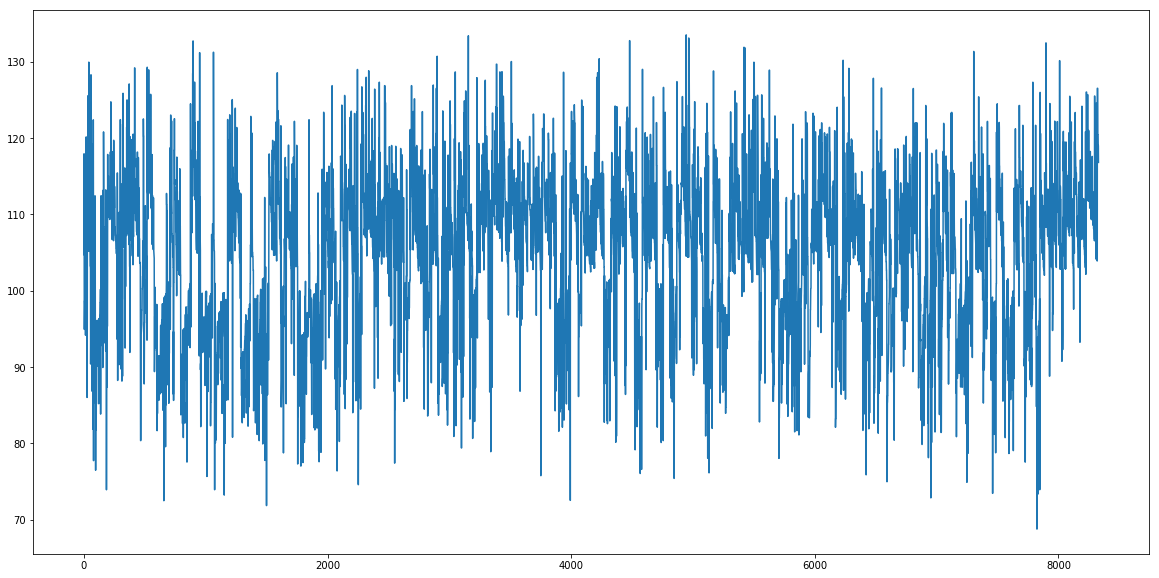

In [39]:
x = np.array(stock.trades)[:,0]
plt.figure(figsize=(20,10))
plt.plot(x)
plt.show()